In [1]:
#Import Packages
import ROOT as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import pickle
import scipy
import numba
from numba import jit
#Specific Functions
from matplotlib.colors import LogNorm
from matplotlib.font_manager import FontProperties
from scipy.signal import argrelextrema
# For plots
%matplotlib inline
from scipy.stats import gaussian_kde

Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-bhks202p because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


import torch_geometric

In [2]:
def Shower_Clustering(Shower_l, Shower_t, Shower_r):
    #Define Centers
    Shower_Centers = np.array([[-5.28,0.00,5.28], # X
                               [-3.05,6.10,-3.05], # Y
                               [3,3,3]]) #Z
    
    #Shower Modules
    #Adjust Based on MIP for Run
    Shower_MIPs = [37.5,37.5,37.5]
    Modules = np.column_stack([Shower_l/Shower_MIPs[0], Shower_t/Shower_MIPs[1], Shower_r/Shower_MIPs[2]])
    
    #Calculations
    m_logWeightBase=3.6 #Wighting parameter
    Shower_Sums = Modules.sum(axis=1) #Get shower sum
    test_weights = m_logWeightBase + np.log((Modules+0.0001)/Shower_Sums[:,None]) #Get initial weights in 3-column array
    weights = test_weights*(test_weights > 0) #Check weights by keeping calculated weights > 0, which makes the rest 0
    weight_sums = weights.sum(axis=1) #Sum weights over 3 axes
    
    #Calc Shower Centers
    x = (Shower_Centers[0,:] * weights).sum(axis=1)
    y = (Shower_Centers[1,:] * weights).sum(axis=1)
    z = (Shower_Centers[2,:] * weights).sum(axis=1)

    #Calc weighted centers
    Sh_x =  x / weight_sums
    Sh_y =  y / weight_sums
    Sh_z =  z / weight_sums
    
    return Sh_x, Sh_y, Sh_z


"/volatile/halla/solid/tianye/container/HallC_beamtest_18deg_simulation_files/"

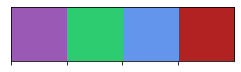

In [3]:
best_colors = ["#9b59b6", "#2ecc71", "cornflowerblue","firebrick"]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

datafile0 = "/volatile/halla/solid/tianye/container/HallC_beamtest_18deg_simulation_files/HallC_beamtest_eAll_LD2_18deg_filenum9991_9.991e8_10.6GeV_shielding_30x30x2.5cm3_poly_beamline_reduce_tree_rate_40uA_Q210MeV_Npe.root"

upfile = uproot.open(datafile0)
upfile.keys()

## Import Sim

In [4]:
%%time

ele_Sim =  pd.read_pickle("SavedSim_Pencil/e_tid1.pkl").copy()
gamma_Sim =  pd.read_pickle("SavedSim_Pencil/gamma_tid1.pkl").copy()
pim_Sim =  pd.read_pickle("SavedSim_Pencil/pim_tid1.pkl").copy()
bkg_Sim = pd.read_pickle("SavedSim_Pencil/BeamOnTarget.pkl").copy()

raw_sim_df = ele_Sim.append([gamma_Sim, pim_Sim], ignore_index=1).copy()
raw_sim_df["theta"] = np.arccos(raw_sim_df["pz"]/raw_sim_df["p"]) * (180/np.pi)
sim_df = raw_sim_df#[((raw_sim_df["theta"]>17) & (raw_sim_df["theta"]<19)) ].copy()

#Remove extra
del ele_Sim, gamma_Sim, pim_Sim


CPU times: user 5min 42s, sys: 39.9 s, total: 6min 22s
Wall time: 6min 28s


In [5]:
#Adjust Rate
sim_df["rate"][sim_df["pid"]==-211] = 20
sim_df["rate"][sim_df["pid"]==11] = 0.0003

sim_df

<ipython-input-5-88d3c18eccf2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_df["rate"][sim_df["pid"]==-211] = 20
<ipython-input-5-88d3c18eccf2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sim_df["rate"][sim_df["pid"]==11] = 0.0003


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_y,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta
0,0.0003,0.0,0.0,0.0,-0.234481,2.871560e-17,0.721657,0.758795,11,743.066040,...,[0.50099778175354],[0.50099778175354],[-673.5350341796875],0.000904,0.000904,0.000904,0.036460,27.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 2.0, 0.0, 1.0, ...",18.000007
1,0.0003,0.0,0.0,0.0,-2.981923,3.651803e-16,9.177417,9.649707,11,6910.143066,...,[-0.420375257730484],[-0.420375257730484],[-672.1791381835938],0.002967,0.002967,0.002967,0.032077,35.0,"[0.0, 5.0, 3.0, 0.0, 1.0, 7.0, 6.0, 1.0, 1.0, ...",17.999995
2,0.0003,0.0,0.0,0.0,-0.911992,1.116868e-16,2.806822,2.951267,11,2877.891602,...,[0.244777649641037],[0.244777649641037],[-672.8071899414062],0.000547,0.000547,0.000547,0.024543,25.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0, 1.0, 0.0, ...",17.999995
3,0.0003,0.0,0.0,0.0,-2.397427,2.936001e-16,7.378521,7.758236,11,7744.224609,...,[-0.3834035396575928],[-0.3834035396575928],[-672.3024291992188],0.000286,0.000286,0.000286,0.020833,25.0,"[0.0, 1.0, 0.0, 0.0, 2.0, 3.0, 5.0, 0.0, 1.0, ...",17.999995
4,0.0003,0.0,0.0,0.0,-2.853923,3.495048e-16,8.783473,9.235490,11,7368.849121,...,[0.2960522472858429],[0.2960522472858429],[-674.8546142578125],0.000818,0.000818,0.000818,0.026032,33.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 1.0, 1.0, ...",17.999995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000987,20.0000,0.0,0.0,0.0,-1.573952,1.927535e-16,4.844126,5.093416,-211,5085.679688,...,[0.3960437476634979],[0.3960437476634979],[-671.8627319335938],0.000463,0.000463,0.000463,0.034769,6.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, ...",17.999995
5000988,20.0000,0.0,0.0,0.0,-2.191752,2.684122e-16,6.745520,7.092659,-211,7085.326660,...,[0.4454308748245239],[0.4454308748245239],[-673.2536010742188],0.000079,0.000079,0.000079,0.033819,21.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 0.0, 0.0, ...",18.000007
5000989,20.0000,0.0,0.0,0.0,-1.127889,1.381266e-16,3.471285,3.649925,-211,3640.323242,...,[0.1406821608543396],[0.1406821608543396],[-672.0704345703125],0.000477,0.000477,0.000477,0.021713,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007
5000990,20.0000,0.0,0.0,0.0,-2.760364,3.380470e-16,8.495525,8.932724,-211,8924.052734,...,[-0.5401169657707214],[-0.5401169657707214],[-672.4806518554688],0.000736,0.000736,0.000736,0.029953,31.0,"[0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 3.0, 0.0, 1.0, ...",17.999995


In [5]:
%%time
##Export to CSV
all_sim = sim_df
#Get NCh
channel_list = [[] for _ in range(16)]
    
for row in all_sim["Cer"]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T
#np.savetxt("Sim_CSV/Sim_Pencil_CherChannels_AllEvents_TID1.csv", Cer_array, delimiter=",")

all_sim["NCh"] = (Cer_array>0).sum(axis=1)


#Export to CSV
#all_sim_np = (all_sim.iloc[:,list((all_sim.dtypes != object).values)]).to_numpy()
#np.savetxt("Sim_CSV/Sim_Pencil_AllEvents_TID1.csv", all_sim_np, 
#           header=','.join(list((all_sim.columns[((all_sim.dtypes != object).values)]).values)), 
#           delimiter=",")


CPU times: user 36.1 s, sys: 2.04 s, total: 38.1 s
Wall time: 38 s


In [4]:
%%time
sim_df = pd.read_pickle("SavedSim_Pencil/Sample500k_tid1.pkl").copy()
bkg_Sim = pd.read_pickle("SavedSim_Pencil/BeamOnTarget.pkl").copy()
bkg_Sim["pid"] = 0

sim_df

CPU times: user 36.3 s, sys: 3.05 s, total: 39.4 s
Wall time: 39.6 s


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_y,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta
3732594,1.0,0.0,0.0,0.0,-0.245253,3.003484e-17,0.754811,0.793656,-211,796.727905,...,[],[],[],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007
4725153,1.0,0.0,0.0,0.0,-1.240131,1.518722e-16,3.816730,4.013148,-211,3968.349121,...,[-0.13848549127578735],[-0.13848549127578735],[-672.5571899414062],0.000302,0.000302,0.000302,0.019188,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995
1853081,1.0,0.0,0.0,0.0,-0.021451,2.626968e-18,0.066019,0.069416,22,69.416313,...,[8.237280215567244e-14],[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007
890558,1.0,0.0,0.0,0.0,-0.646069,7.912063e-17,1.988396,2.090723,11,2014.074219,...,[-3.3478028774261475],[-3.3478028774261475],[-673.6346435546875],0.001236,0.001236,0.001236,0.031869,34.0,"[0.0, 0.0, 0.0, 0.0, 2.0, 5.0, 0.0, 0.0, 9.0, ...",18.000007
2763099,1.0,0.0,0.0,0.0,-2.357336,2.886904e-16,7.255134,7.628500,22,7628.499512,...,[8.237280215567244e-14],[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595837,1.0,0.0,0.0,0.0,-2.763434,3.384231e-16,8.504975,8.942660,11,8931.000000,...,[-0.4629770815372467],[-0.4629770815372467],[-673.144287109375],0.000983,0.000983,0.000983,0.033490,33.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 5.0, 5.0, 0.0, 4.0, ...",18.000007
1229046,1.0,0.0,0.0,0.0,-2.768061,3.389897e-16,8.519217,8.957634,11,8947.375000,...,[0.15346860885620117],[0.15346860885620117],[-672.5138549804688],0.000657,0.000657,0.000657,0.031047,39.0,"[0.0, 2.0, 0.0, 0.0, 2.0, 7.0, 6.0, 2.0, 2.0, ...",17.999995
1241502,1.0,0.0,0.0,0.0,-0.161126,1.973226e-17,0.495895,0.521415,11,511.886932,...,[],[],[],0.000000,0.000000,0.000000,0.000000,3.0,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995
4277548,1.0,0.0,0.0,0.0,-1.477411,1.809307e-16,4.547004,4.781003,-211,4773.166504,...,[0.5832517147064209],[0.5832517147064209],[-672.9967651367188],0.000940,0.000940,0.000940,0.025409,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",17.999995


In [10]:
%%time
bkg_Sim = pd.read_pickle("SavedSim_Pencil/BeamOnTarget.pkl").copy()
bkg_Sim["pid"] = (0*bkg_Sim["pid"].values).astype(int)

#Get NCh
channel_list = [[] for _ in range(16)]
    
for row in bkg_Sim["Cer"]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T
#np.savetxt("Sim_CSV/Bkg_CherChannels_500k.csv", Cer_array, delimiter=",")

bkg_Sim["NCh"] = (Cer_array>0).sum(axis=1)

#Export Bkg
#bkg_Sim_np = (bkg_Sim.iloc[:,list((bkg_Sim.dtypes != object).values)]).to_numpy()
#np.savetxt("Sim_CSV/Sim_Pencil_Bkg.csv", bkg_Sim_np, 
#           header=','.join(list((bkg_Sim.columns[((bkg_Sim.dtypes != object).values)]).values)), 
#           delimiter=",")

bkg_Sim

CPU times: user 11 s, sys: 431 ms, total: 11.5 s
Wall time: 11.4 s


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_y,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,NCh
0,31268.761719,-0.150747,0.085143,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,31268.761719,-0.083738,0.091032,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,31268.761719,-0.125564,-0.089462,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,31268.761719,-0.133680,0.135885,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,31268.761719,-0.107184,-0.075538,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146963,31268.761719,-0.126608,-0.065543,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
146964,31268.761719,-0.013812,-0.221830,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
146965,31268.761719,0.009032,-0.032966,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
146966,31268.761719,-0.055848,-0.105311,-40.0,0.0,0.0,10.6,10.6,0,0.0,...,[],[],[],0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [5]:
sim_df[["rate","pid"]].groupby("pid").count()

,rate
pid,
-211,1560356
11,1819916
22,1620720


In [5]:
%%time

all_sim = sim_df

#Get NCh
channel_list = [[] for _ in range(16)]
    
for row in all_sim["Cer"]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T
np.savetxt("Sim_CSV/Sim_CherChannels.csv", Cer_array, delimiter=",")

all_sim["NCh"] = (Cer_array>0).sum(axis=1)

all_sim

CPU times: user 6.87 s, sys: 202 ms, total: 7.08 s
Wall time: 7.1 s


,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_vy,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta,NCh
1271445,1.0,0.0,0.0,0.0,-1.749860,2.142961e-16,5.385516,5.662666,11,5652.867188,...,[0.43061283230781555],[-672.59765625],0.000489,0.000489,0.000489,0.033901,37.0,"[0.0, 1.0, 5.0, 0.0, 1.0, 10.0, 5.0, 1.0, 0.0,...",17.999995,10
1291198,1.0,0.0,0.0,0.0,-1.574065,1.927673e-16,4.844473,5.093781,11,5084.132324,...,"[-0.1973210871219635, -0.025781411677598953]","[-673.155517578125, -673.4472045898438]",0.000658,0.000658,0.000658,0.027569,33.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 6.0, 0.0, 2.0, ...",17.999995,8
3040514,1.0,0.0,0.0,0.0,-1.891029,2.315843e-16,5.819989,6.119498,22,6119.498535,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0
1664542,1.0,0.0,0.0,0.0,-1.646170,2.015977e-16,5.066392,5.327120,11,5315.209961,...,[0.16852334141731262],[-672.6641845703125],0.000500,0.000500,0.000500,0.042199,29.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 6.0, 5.0, 0.0, 0.0, ...",18.000007,8
718312,1.0,0.0,0.0,0.0,-2.578831,3.158158e-16,7.936827,8.345273,11,3980.122803,...,"[-0.3597544729709625, -0.39764633774757385, -0...","[-672.5665893554688, -672.49853515625, -672.54...",0.000505,0.000505,0.000505,0.026060,27.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 7.0, 0.0, 2.0, ...",17.999995,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4035089,1.0,0.0,0.0,0.0,-0.795842,9.746250e-17,2.449349,2.575398,-211,2570.215088,...,[-2.4318504333496094],[-669.1513061523438],0.001601,0.001601,0.001601,0.024468,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.000007,0
1954273,1.0,0.0,0.0,0.0,-0.430305,5.269720e-17,1.324343,1.392497,22,1392.497070,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0
3810076,1.0,0.0,0.0,0.0,-2.538567,3.108848e-16,7.812905,8.214974,-211,8206.588867,...,[0.2854882776737213],[-673.2467041015625],0.000446,0.000446,0.000446,0.034741,18.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, ...",18.000007,6
3270677,1.0,0.0,0.0,0.0,-0.188715,2.311092e-17,0.580805,0.610695,22,610.694641,...,[8.237280215567244e-14],[-672.6249389648438],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.999995,0


## Get Sample Sim

In [36]:
(sim_df["Npesum"][(sim_df["pid"]==11)]==0).sum()/((sim_df["pid"]==11).sum())

0.01717002323184147

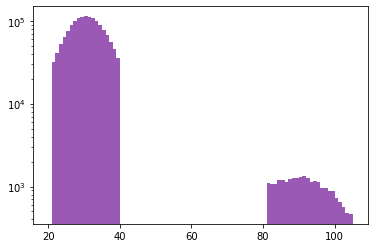

In [43]:
plt.hist(check_df["Npesum"],bins=np.arange(20,106,1))
plt.yscale("log")

<ipython-input-44-09ef777906e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df["Type"] = ((sim_df["Npesum"]>80)&(sim_df["Npesum"]<105))


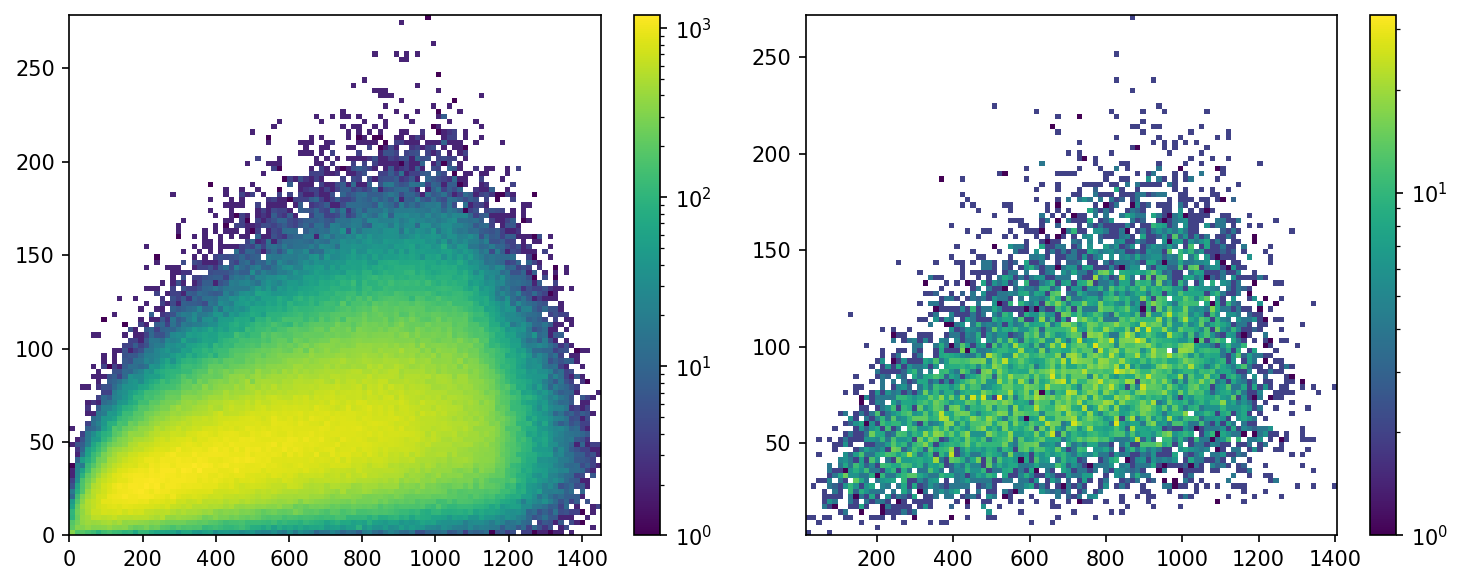

In [44]:
check_df = (sim_df[(sim_df["pid"]==11) & (((sim_df["Npesum"]>20)&(sim_df["Npesum"]<40)) | 
                                          ((sim_df["Npesum"]>80)&(sim_df["Npesum"]<105)))])

check_df["Type"] = ((sim_df["Npesum"]>80)&(sim_df["Npesum"]<105))

np.unique(check_df["Type"],return_counts=1)


plt.figure(dpi=150, figsize=(10,4))
plt.subplot(1,2,1)
plt.hist2d(check_df["ShowerSum"][check_df["Type"]==0],check_df["PreShSum"][check_df["Type"]==0], 
           norm=LogNorm(), bins=100)
plt.colorbar()
plt.subplot(1,2,2)
plt.hist2d(check_df["ShowerSum"][check_df["Type"]==1],check_df["PreShSum"][check_df["Type"]==1], 
           norm=LogNorm(), bins=100)
plt.colorbar()

plt.tight_layout()

In [7]:
%%time
#Get Sample
samp_sim = sim_df.sample(n=int(5e5), random_state=42)

#Pickle
name = "Sample500k_tid1"
samp_sim.to_pickle(f"SavedSim_Pencil/{name}.pkl")

#Export to CSV
samp_sim_np = (samp_sim.iloc[:,list((samp_sim.dtypes != object).values)]).to_numpy()
np.savetxt("Sim_CSV/Sim_Pencil_Sample500k.csv", samp_sim_np, 
           header=','.join(list((samp_sim.columns[((samp_sim.dtypes != object).values)]).values)), 
           delimiter=",")

samp_sim[["rate","pid"]].groupby("pid").count()

CPU times: user 1min 3s, sys: 29.3 s, total: 1min 32s
Wall time: 1min 32s


,rate
pid,
-211,155951
11,182035
22,162014


In [10]:
%%time
sim_np = (all_sim.iloc[:,list((all_sim.dtypes != object).values)]).to_numpy()
#sim_np = (all_sim.iloc[:,np.array(list((all_sim.dtypes != object).values)) + np.array(all_sim.columns=="Cer")]).to_numpy()

np.savetxt("Sim_CSV/Sim_Pencil.csv", sim_np, header=','.join(list((all_sim.columns[((all_sim.dtypes != object).values)]).values)), 
           delimiter=",")

CPU times: user 3min 31s, sys: 12.6 s, total: 3min 43s
Wall time: 3min 43s


## Overview

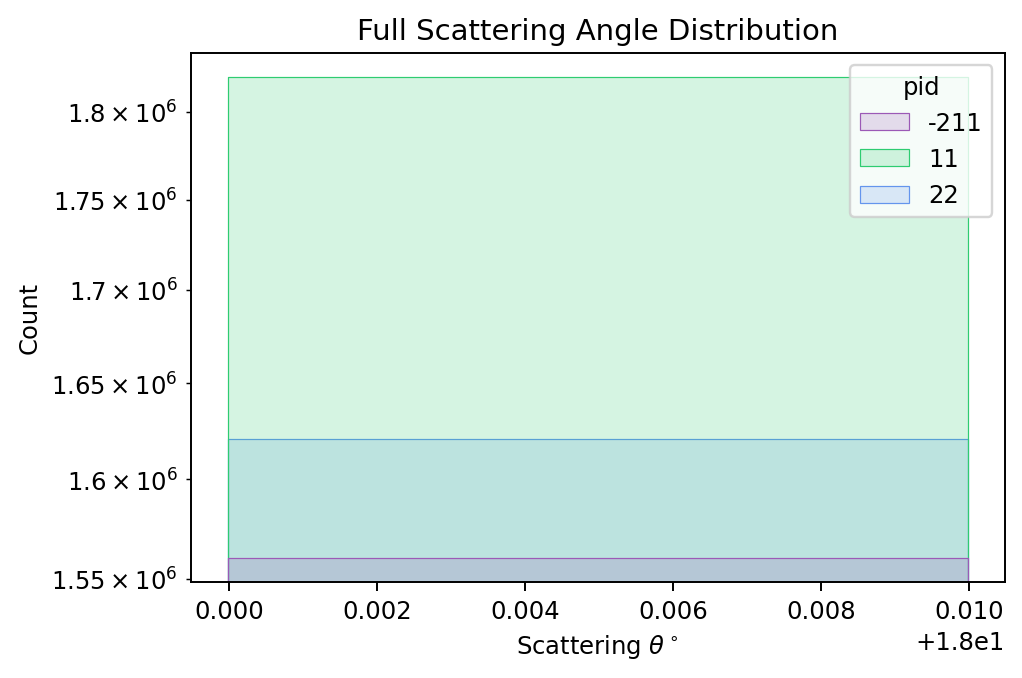

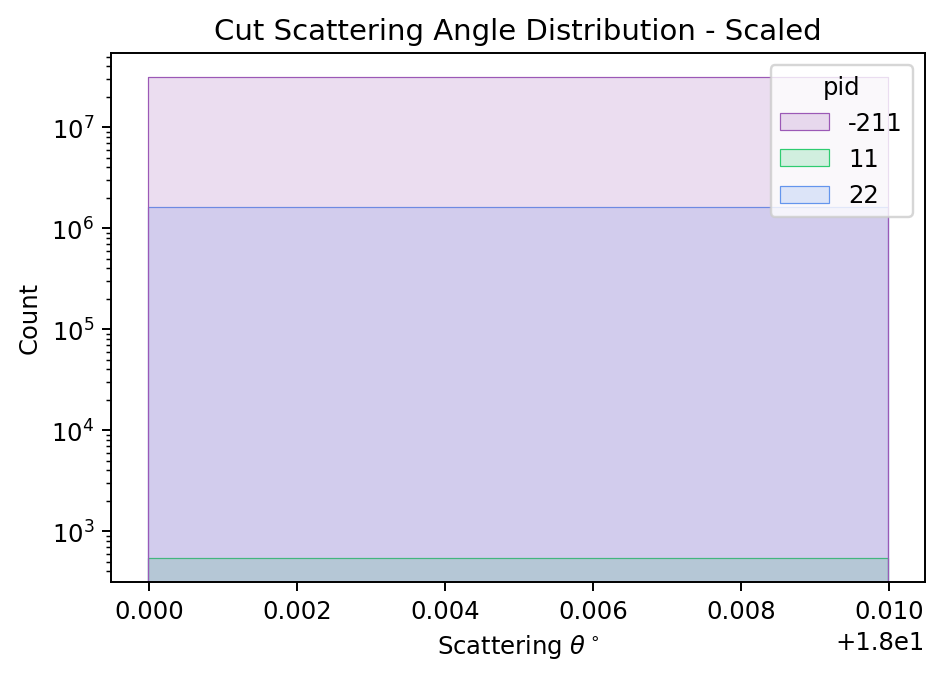

In [7]:
plt.figure(dpi=175)
plt.title("Full Scattering Angle Distribution")
sns.histplot(raw_sim_df, x="theta", binwidth=.01, hue="pid", element="step", lw=.5, #weights = "rate", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.2)

plt.xlabel("Scattering $\\theta^\circ$")
plt.yscale("log")
#plt.xticks(np.arange(0,45,1), minor=1)
#plt.savefig("Plots/NewCher_FullScatteringAngle.pdf")
plt.show()


plt.figure(dpi=175)
plt.title("Cut Scattering Angle Distribution - Scaled")
sns.histplot(all_sim, x="theta", binwidth=.01, hue="pid", element="step", weights = "rate", lw=0.5,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.2)

plt.xlabel("Scattering $\\theta^\circ$")
plt.yscale("log")
#plt.xticks(np.arange(16.9,19.1,.25), minor=1)
#plt.savefig("Plots/NewCher_CutScatteringAngle_Scaled.pdf")
plt.show()


In [26]:
np.tile(np.arange(1,10),5) * 10**np.repeat(np.arange(5),9)

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    20,    30,    40,    50,    60,    70,    80,    90,
         100,   200,   300,   400,   500,   600,   700,   800,   900,
        1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000])

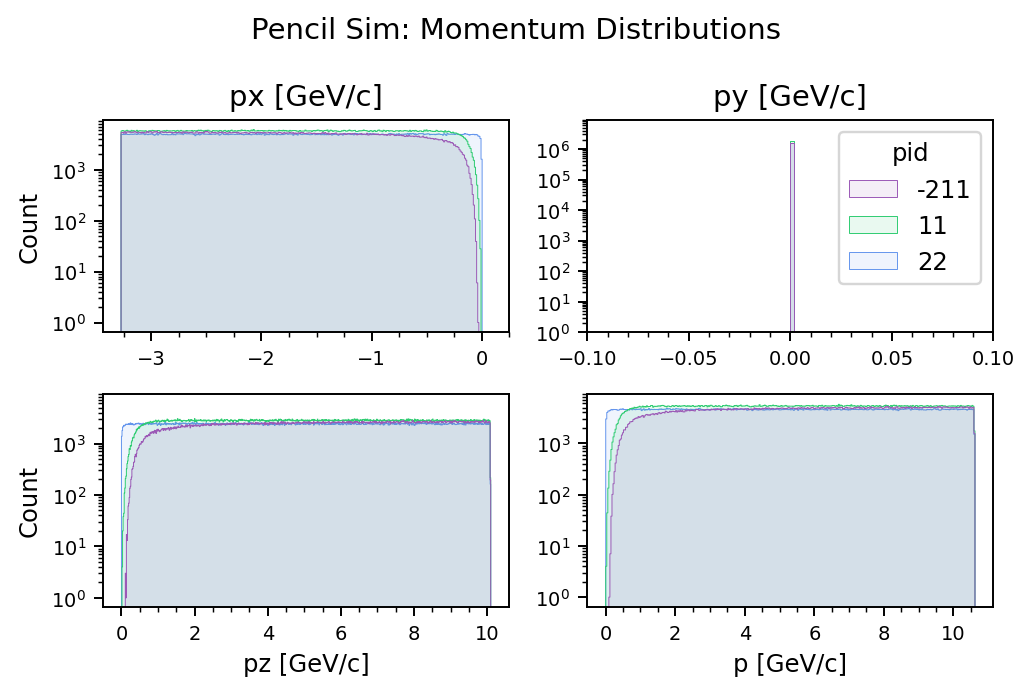

CPU times: user 17.8 s, sys: 5.51 s, total: 23.3 s
Wall time: 22.3 s


In [38]:
%%time
all_sim = sim_df
columns = ["px","py","pz","p"]
widths = [0.01, 0.002, 0.015, 0.03]
xlims = [[-3.25,.2501],[-.1,.101],[0,10.5],[0,11]]
x_tick_space = [.25,.01,.5,.5]
y_tick_height = [4,7,4,4]
locs = ["upper left","upper left","upper right"]
leg_val = [0,1,0,0]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle(f"Pencil Sim: Momentum Distributions")

keeps = all_sim["Npesum"]>-20

for i in range(4):
    axes[int(i/2),i%2].set_title(f"{columns[i]}")
    sns.histplot(all_sim[keeps], x=columns[i], binwidth=widths[i], hue="pid", element="step", #weights="rate",
                 linewidth=.4, palette=sns.color_palette(best_colors[:-1]), alpha=0.1, ax=axes[int(i/2),i%2], legend=leg_val[i])
    
    axes[int(i/2),i%2].set_yscale("log")
    axes[int(i/2),i%2].set_xticks(np.arange(xlims[i][0],xlims[i][1],x_tick_space[i]), minor=1)
    
    axes[int(i/2),i%2].set_yticks(10**np.arange(y_tick_height[i]))
    axes[int(i/2),i%2].set_yticks(np.tile(np.arange(1,10),y_tick_height[i]) * 10**np.repeat(np.arange(y_tick_height[i]),9), 
                                  minor=1)
    
    if i==1:
        axes[int(i/2),i%2].set_xticks(np.arange(-.1,.11,.05))
        axes[int(i/2),i%2].set_xticks(np.arange(-.1,.11,.01), minor=1)
    
    axes[int(i/2),i%2].tick_params(axis="both", which="major", labelsize=8)
    axes[int(i/2),i%2].tick_params(axis="both", which="minor", labelsize=0)

#axes[0,0].set_xlim(-0.2,1.05)
#axes[0,1].set_xlim(-0.3,.3)

#Formatting
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[1,0].set_xlabel(f"{columns[2]} [GeV/c]")
axes[1,1].set_xlabel(f"{columns[3]} [GeV/c]")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[0,0].set_title(f"{columns[0]} [GeV/c]")
axes[0,1].set_title(f"{columns[1]} [GeV/c]")
axes[1,0].set_title("")
axes[1,1].set_title("")

#plt.savefig("SpecificPlots/Sim_Plots/Deg18_Sim_Momentum_Dist_raw.pdf")
plt.tight_layout()
#fig.legend(title='pid', loc=7, labels=[22,11,-211], prop={"size":6})

plt.savefig("Plots/ForReport/Pencil_FullMomentumDists.pdf")
plt.show()
    

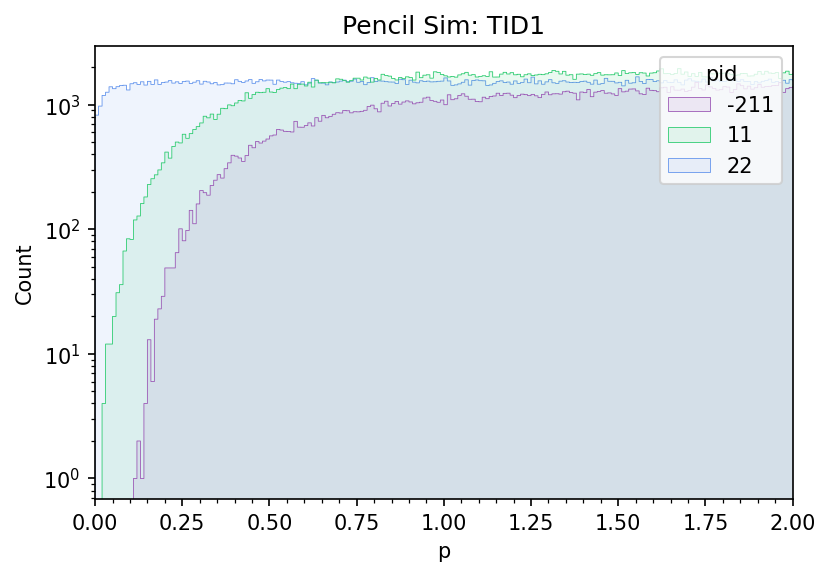

In [49]:
fig = plt.figure(dpi=150)
plt.title("Pencil Sim: TID1")
all_sim = sim_df#[(sim_df["PreShSum"]+sim_df["ShowerSum"])==0]

ax = sns.histplot(all_sim, x="p", binwidth=.01, hue="pid", 
                  element="step", #weights="rate",
                  linewidth=.4, palette=sns.color_palette(best_colors[:-1]), alpha=0.1)

plt.xlim(0,2)
ax.set_xticks(np.arange(0,2.01,.05),minor=1)

plt.yscale("log")


#plt.show()

In [66]:
pid_base_counts.shape

(3, 40)

In [65]:

np.tile(bins,(3,1)).shape

(3, 41)

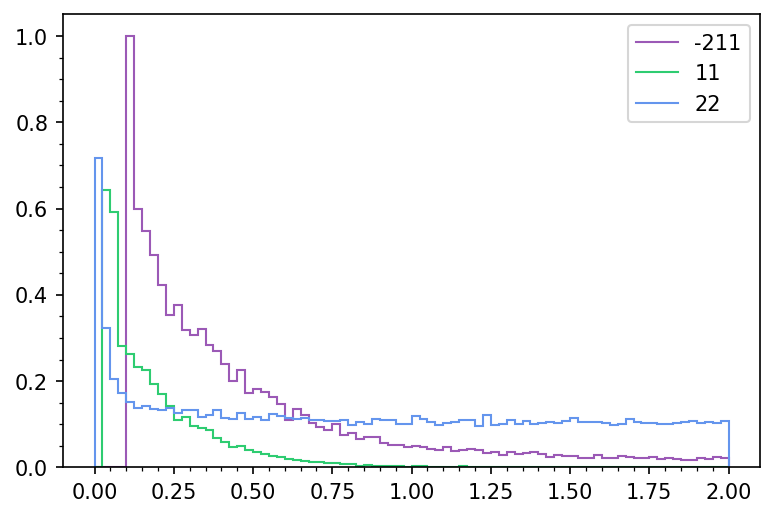

In [79]:
fig,ax = plt.subplots(dpi=150)

pid_base_counts = []
pid_cut_counts = []

for pid in [-211, 11, 22]:
    counts, bins = np.histogram(sim_df["p"][(sim_df["pid"]==pid)], bins=np.arange(0,2.01,.025))
    cut_counts, cut_bins = np.histogram(sim_df["p"][(sim_df["ShowerSum"]==0) & (sim_df["pid"]==pid)], bins=np.arange(0,2.01,.025))
    
    pid_base_counts.append(counts)
    pid_cut_counts.append(cut_counts)
    
pid_base_counts, pid_cut_counts = np.array(pid_base_counts), np.array(pid_cut_counts)

for i in range(3):
    plt.stairs((pid_cut_counts[i])/(pid_base_counts[i]+.0001), bins, label=f"{[-211, 11, 22][i]}")

ax.set_xticks(np.arange(0,2.01,.05), minor=1)
ax.set_yticks(np.arange(0,1.01,.05), minor=1)

plt.legend()

## NPE vs p

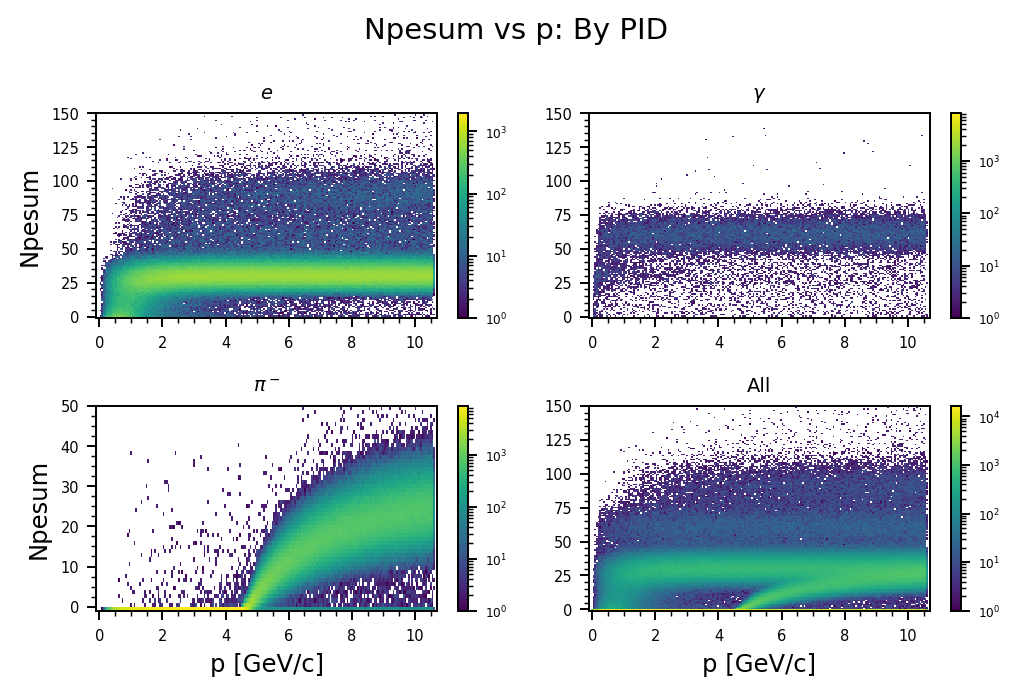

In [36]:
# Loop Over Shower Vals
columns =["p","Npesum"]
x_bin = [50, 5,5,5]

ylimits=[150,150,50,150]
y_ticks=[5,5,2.5,5]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Npesum vs p: By PID")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], 
                                                         range=((-.1,10.7),(-1,ylimits[j])),
                                                         #limits[j], 
                                                         #weights=plot_sim["rate"],
                                                         bins=[200,ylimits[j]], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=5)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]} [GeV/c]")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,10.6,.5), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,ylimits[j],y_ticks[j]), minor=1)    
    
    axes[int(j/2),j%2].tick_params(axis="both", which="major", labelsize=6)#, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/Pencil_NPE_p_TID1.pdf")   #AngleCut
plt.savefig("Plots/ForReport/FullPencil_NPE_p_TID1.pdf")


## Showers

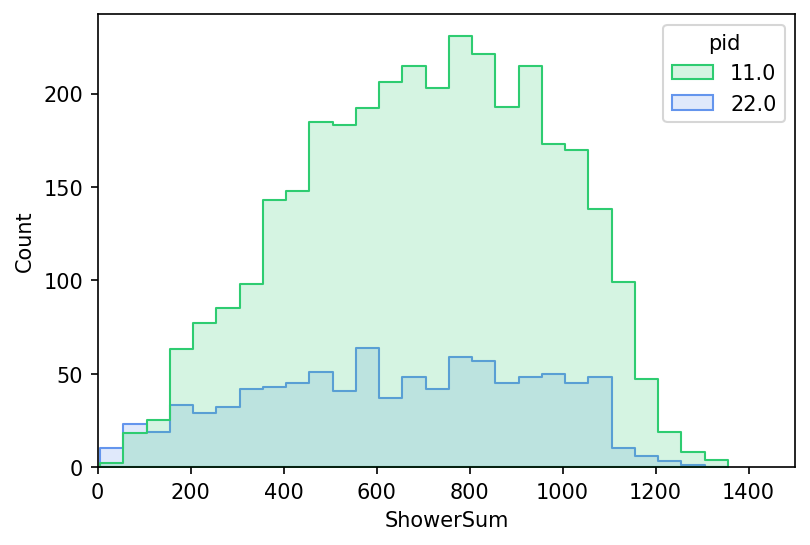

In [35]:
plot_sim = sim_df#[((sim_df["PreSh_l"]/sim_df["PreShSum"])>.95)] #[(sim_df["Npesum"]==0)

plt.figure(dpi=150)
sns.histplot(plot_sim[plot_sim["Npesum"]>75], x=plot_sim["ShowerSum"], hue="pid", #weights="rate", 
             palette=sns.color_palette(best_colors[1:-1]), 
             binwidth=50, alpha=0.2, element="step")

#sns.histplot(bkg_Sim, x=plot_sim["PreSh_l"], hue="pid", #weights="rate", 
#             color=best_colors[0], legend=0,
#             binwidth=.025, alpha=0.2, element="step")

plt.xlim(0,1500)
#plt.ylim(0,200)
#plt.yscale("log")
plt.show()

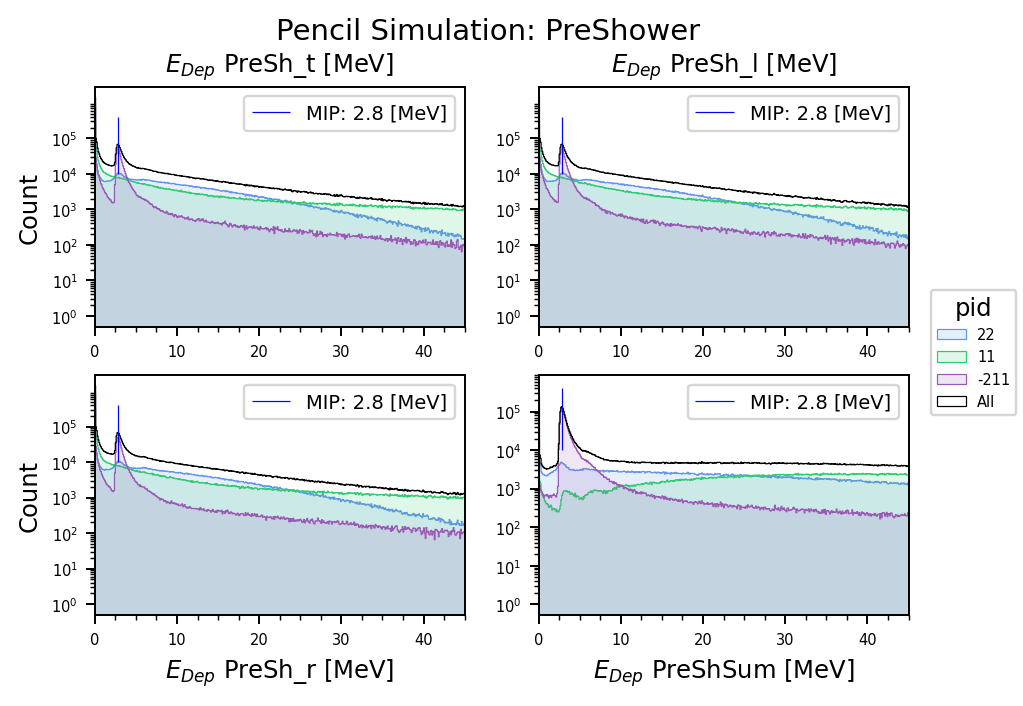

In [54]:
#
sim_MIPs = [2.8, 2.8, 2.8, 2.8]

fig, axes = plt.subplots(2, 2, dpi=175)

plot_sim = sim_df#[(sim_df["ShowerSum"]>0) & ((np.abs(sim_df["theta"]-81) < 2))]
bin_len = 0.1


#By Particle
sns.histplot(plot_sim, x= "PreSh_t",  hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]),
             #weights = "rate",
             alpha=0.15, ax= axes[0,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_l",  hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]), 
             #weights = "rate",
             alpha=0.15, ax= axes[0,1], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_r",  hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]), 
             #weights = "rate",
             alpha=0.15, ax= axes[1,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreShSum", hue="pid", binwidth=bin_len, element="step", palette=sns.color_palette(best_colors[:-1]), 
             #weights = "rate",
             alpha=0.15, ax= axes[1,1], linewidth=0.5, legend=0)

#All
sns.histplot(plot_sim, x= "PreSh_t",  binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[0,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_l",  binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[0,1], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreSh_r",  binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[1,0], linewidth=0.5, legend=0)
sns.histplot(plot_sim, x= "PreShSum", binwidth=bin_len, element="step", color="black", 
             #weights="rate",
             alpha=0, ax= axes[1,1], linewidth=0.5, legend=0)


fig.legend(title='pid', loc=7, labels=[22,11,-211,"All"], prop={"size":6})

#Log Scale
axes[0,0].set_yscale("log")
axes[0,1].set_yscale("log")
axes[1,0].set_yscale("log")
axes[1,1].set_yscale("log")

#Vlines
axes[0,0].vlines(sim_MIPs[0], 1e4, 4e5, label=f"MIP: {sim_MIPs[0]} [MeV]", linewidths=.5, color="blue")
axes[0,1].vlines(sim_MIPs[1], 1e4, 4e5, label=f"MIP: {sim_MIPs[1]} [MeV]", linewidths=.5, color="blue")
axes[1,0].vlines(sim_MIPs[2], 1e4, 4e5, label=f"MIP: {sim_MIPs[2]} [MeV]", linewidths=.5, color="blue")
axes[1,1].vlines(sim_MIPs[3], 1e4, 4e5, label=f"MIP: {sim_MIPs[3]} [MeV]", linewidths=.5, color="blue")

#Show Labels
axes[0,0].legend(prop={"size":8})
axes[0,1].legend(prop={"size":8})
axes[1,0].legend(prop={"size":8})
axes[1,1].legend(prop={"size":8})

#Titles
fig.suptitle(f"Pencil Simulation: PreShower")
axes[0,0].set_title("$E_{Dep}$ PreSh_t [MeV]", fontsize=10)
axes[0,1].set_title("$E_{Dep}$ PreSh_l [MeV]", fontsize=10)
axes[1,0].set_xlabel("$E_{Dep}$ PreSh_r [MeV]", fontsize=10)
axes[1,1].set_xlabel("$E_{Dep}$ PreShSum [MeV]", fontsize=10)  

axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
#axes[1,0].set_xlabel("")
#axes[1,1].set_xlabel("")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

for j in range(4):
    axes[int(j/2),j%2].set_xticks(np.arange(0,51,10))
    axes[int(j/2),j%2].set_xticks(np.arange(0,51,2.5), minor=1)
    axes[int(j/2),j%2].set_yticks(10**np.arange(6))
    axes[int(j/2),j%2].set_yticks(np.tile(np.arange(1,10),6) * 10**np.repeat(np.arange(6),9), minor=1)
    axes[int(j/2),j%2].set_xlim(0,45)

    axes[int(j/2),j%2].tick_params(axis="both", which="major", labelsize=6)

#plt.tight_layout()
#plt.savefig("Plots/NewCher_PreShower_AngleCut.pdf")
plt.savefig("Plots/ForReport/FullPencil_PreShower_TID1.pdf")
plt.show()

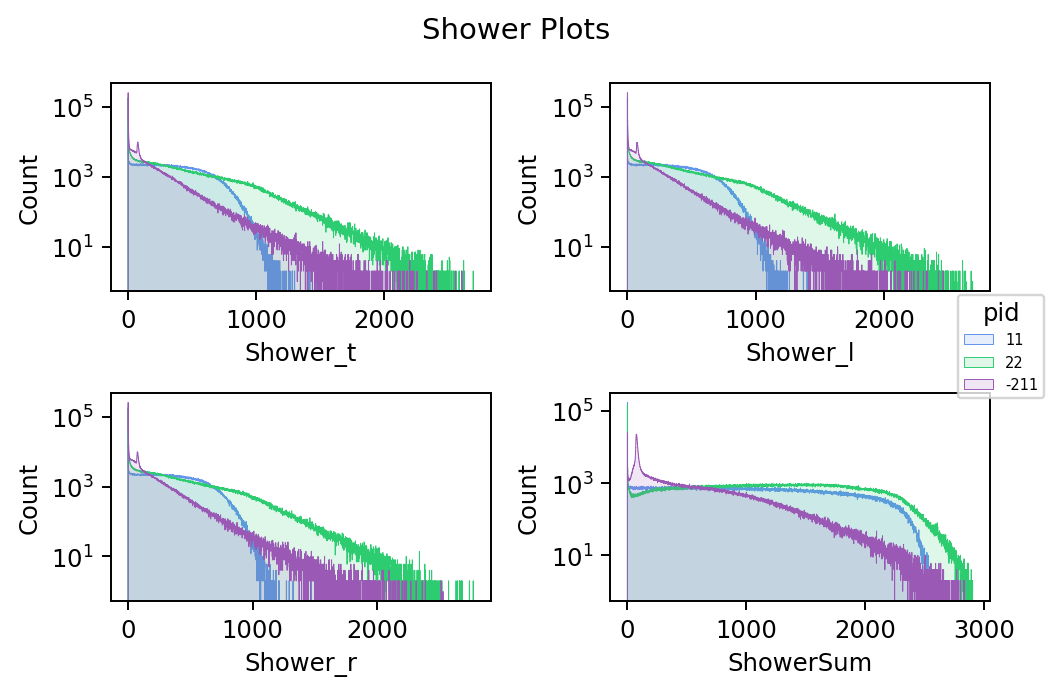

In [60]:
#Variables to plot
plot_vars = ["Shower_t", "Shower_l", "Shower_r", "ShowerSum"]
plot_vars2 = ["PreSh_t", "PreSh_l", "PreSh_r", "PreShSum"]

fig = plt.figure(dpi=175)
plt.suptitle("Shower Plots")

for i in range(4):
    plot_sim = sim_df.append(bkg_Sim)
    width = 2
    
    plt.subplot(2,2,1+i)
    sns.histplot(plot_sim, x=plot_sim[plot_vars[i]] + plot_sim[plot_vars[i]],  hue="pid", #hue_order=[11,22,-211],
                 binwidth=1, element="step", palette=sns.color_palette(best_colors[:-1]), 
                 alpha=0.15, linewidth=0.4, legend=0,
                 #weights="rate"
                )
    #sns.histplot(plot_sim, x=plot_vars[i],  binwidth=width, element="step", color="black", 
    #             alpha=0, linewidth=0.4, legend=0,
    #             weights="rate"
    #            )
    
    #Subplot Formatting
    #plt.vlines(37.5, 1, 10**4, label=f"MIP: {37.5}", linewidths=.5, color="blue")
    #plt.legend(fontsize=8)
    #plt.setp(ax.get_legend().get_title(), fontsize='6')
    #plt.setp(ax.get_legend().get_texts(), fontsize='5')
    
    #plt.xticks(np.arange(0,100+1,5), minor=1)
    #plt.xlim(0,100)
    
    plt.yscale("log")
    #plt.yticks(10.**np.arange(-3,6,1), minor=1, fontsize=0, alpha=0)

    
plt.tight_layout()
fig.legend(title='pid', loc=7, labels=[11,22,-211], prop={"size":6})

#plt.savefig("Plots/NewCher_Shower_AngleCut.pdf")


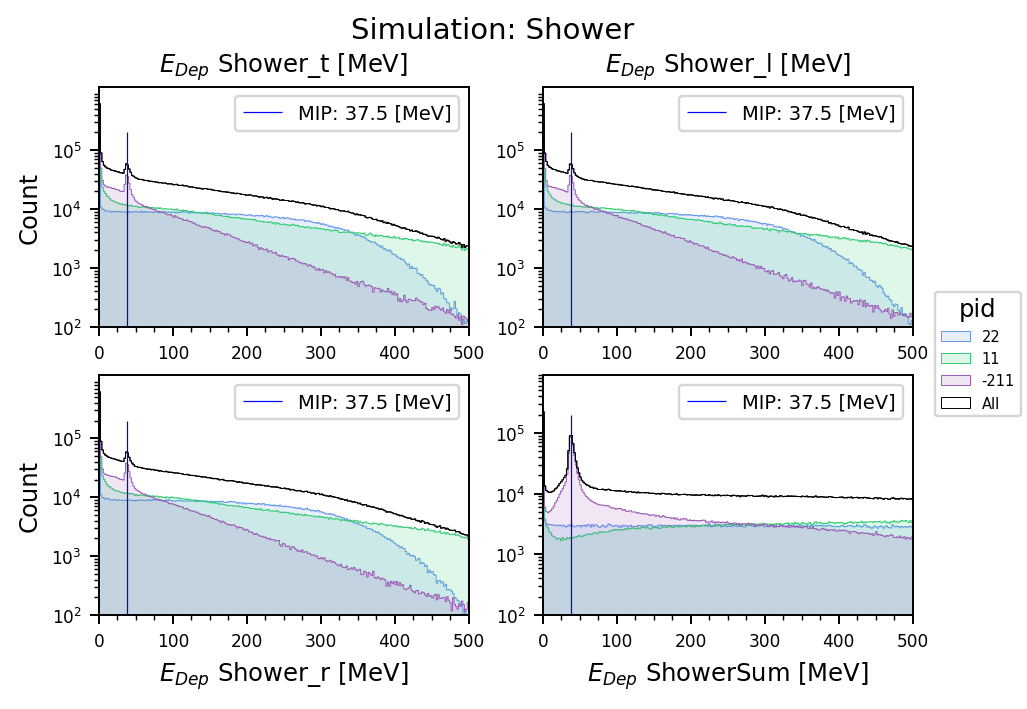

In [53]:
#MIP Peaks
sim_MIPs = [3.2, 3.25, 3.25, 3.25, 10, 10, 10, 10, 9.2, 9.2, 1.0, 3.5, .5, 0, 0]

fig, axes = plt.subplots(2, 2, dpi=175)

plot_sim = sim_df#new_raw_sim_df[(new_raw_sim_df["ShowerSum"]>0) & ((np.abs(new_raw_sim_df["theta"]-81) < 2))]

width=2
#By Particle
sns.histplot(plot_sim, x= "Shower_t",  hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[0,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_l",  hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[0,1], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_r",  hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[1,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "ShowerSum", hue="pid", binwidth=width, element="step", palette=sns.color_palette(best_colors[:-1]), 
                  alpha=0.15, ax= axes[1,1], linewidth=0.4, legend=0)

#All
sns.histplot(plot_sim, x= "Shower_t",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_l",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,1], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_r",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "ShowerSum", binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,1], linewidth=0.4, legend=0)

sns.histplot(plot_sim, x= "Shower_t",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_l",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[0,1], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "Shower_r",  binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,0], linewidth=0.4, legend=0)
sns.histplot(plot_sim, x= "ShowerSum", binwidth=width, element="step", color="black", 
                  alpha=0, ax=axes[1,1], linewidth=0.4, legend=0)


fig.legend(title='pid', loc=7, labels=[22,11,-211,"All"], prop={"size":6})

#Vlines
axes[0,0].vlines(37.5, 1e2, 2e5, label=f"MIP: {37.5} [MeV]", linewidths=.5, color="blue")
axes[0,1].vlines(37.5, 1e2, 2e5, label=f"MIP: {37.5} [MeV]", linewidths=.5, color="blue")
axes[1,0].vlines(37.5, 1e2, 2e5, label=f"MIP: {37.5} [MeV]", linewidths=.5, color="blue")
axes[1,1].vlines(37.5, 1e2, 2e5, label=f"MIP: {37.5} [MeV]", linewidths=.5, color="blue")

#Legends
axes[0,0].legend(prop={"size":8})
axes[0,1].legend(prop={"size":8})
axes[1,0].legend(prop={"size":8})
axes[1,1].legend(prop={"size":8})

#Log Scale
axes[0,0].set_yscale("log")
axes[0,1].set_yscale("log")
axes[1,0].set_yscale("log")
axes[1,1].set_yscale("log")

#Titles
fig.suptitle(f"Simulation: Shower")
axes[0,0].set_title("$E_{Dep}$ Shower_t [MeV]", fontsize=10)
axes[0,1].set_title("$E_{Dep}$ Shower_l [MeV]", fontsize=10)
axes[1,0].set_xlabel("$E_{Dep}$ Shower_r [MeV]", fontsize=10)
axes[1,1].set_xlabel("$E_{Dep}$ ShowerSum [MeV]", fontsize=10)  

axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
#axes[1,0].set_xlabel("")
#axes[1,1].set_xlabel("")

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[1,1].set_xlim(0,600)


for j in range(4):
    axes[int(j/2),j%2].set_xlim(0,500)
    axes[int(j/2),j%2].set_xticks(np.arange(0,501,100))
    axes[int(j/2),j%2].set_xticks(np.arange(0,501,25), minor=1)
    
    axes[int(j/2),j%2].set_ylim(bottom=100)
    axes[int(j/2),j%2].set_yticks(10**np.arange(2,6))
    axes[int(j/2),j%2].set_yticks(np.tile(np.arange(1,10),4) * 10**np.repeat(np.arange(2,6),9), minor=1)

    axes[int(j/2),j%2].tick_params(axis="both", which="major", labelsize=7)

#plt.tight_layout()
plt.savefig("Plots/ForReport/FullPencil_Shower_TID1.pdf")
plt.show()

In [18]:
0.5*194

97.0

## PreSh vs Shower

In [4]:
all_sim = sim_df

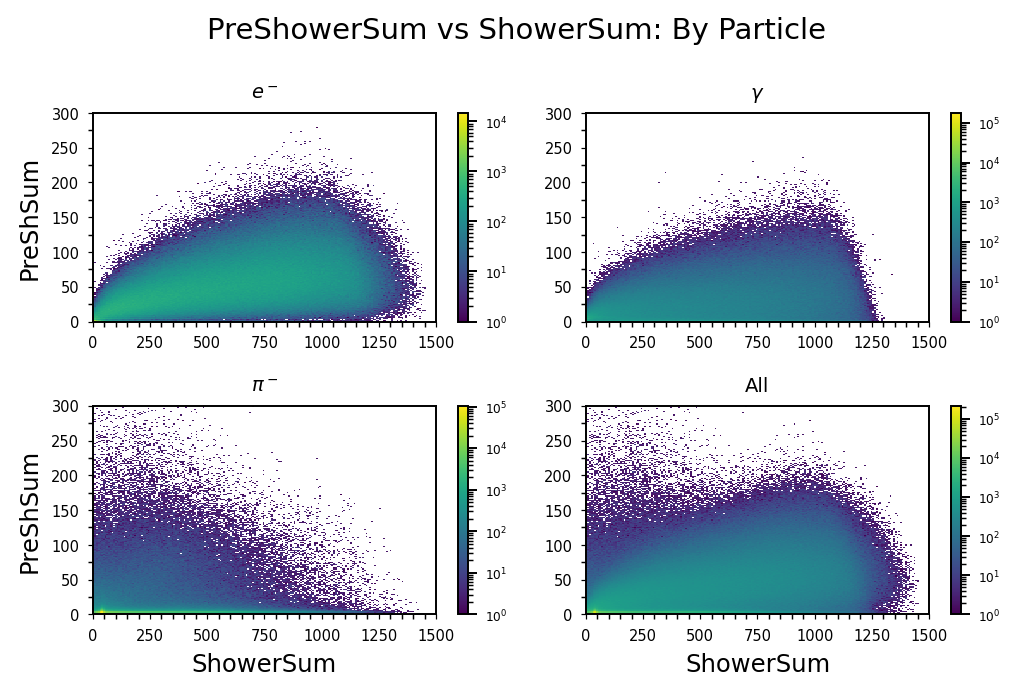

In [52]:
# Loop Over Shower Vals
columns =["ShowerSum","PreShSum"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,1500),(0,300)],[(0,1500),(0,300)],[(0,1500),(0,300)],[(0,1500),(0,300)]] #[[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,150)],[(0,150),(0,100)]]
bins = [(100, 100), (100,100), (100,100), (100,100)]
x_bin = [50, 50,50,50]


particles = ["$e^-$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("PreShowerSum vs ShowerSum: By Particle")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j==3:
        plot_sim = sim_df# & ((sim_df["p"]>3.5) & (sim_df["p"]<3.6))]
    else:
        plot_sim = sim_df[(sim_df["pid"]==part_ids[j])]#

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], 
                                                         plot_sim[f"{columns[1]}"], range=limits[j], 
                                                         #weights=plot_sim["rate"],
                                                         bins=200, #bins[j], 
                                                         norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=5)
    
    #Scaling Line
    #axes[int(j/2),j%2].plot(*line_ests[j], color="lightgreen", label=f"Points: {line_ests[j][1][0]:n}, {line_ests[j][0][1]:n} \nSlope: {(line_ests[j][1][0]/line_ests[j][0][1]):2.3f}")
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,limits[j][0][1],x_bin[j]), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,limits[j][1][1],25), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)

plt.savefig("Plots/ForReport/FullPencil_PreSh_Shower_TID1.pdf")


## LASPD

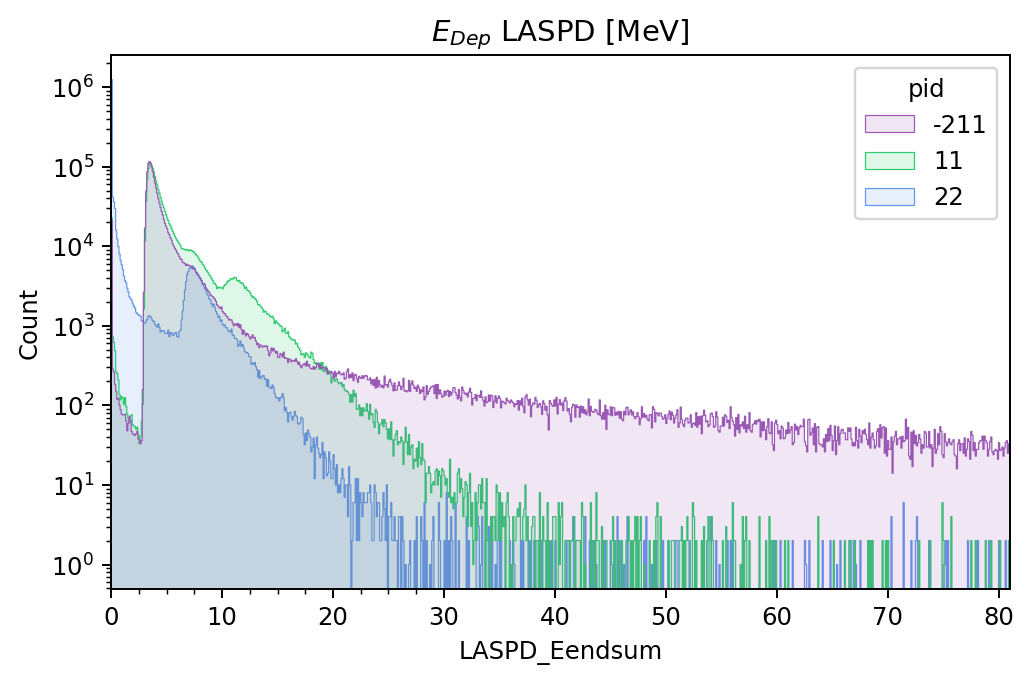

In [61]:
plt.figure(dpi=175)
plt.title("Pencil Simulation: $E_{Dep}$ LASPD [MeV]")

sns.histplot(sim_df, x="LASPD_Eendsum", hue="pid", binwidth=.1, element="step", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
plt.xlim(0,81)
plt.xticks(np.arange(0,31,2.5), minor=1)

plt.tight_layout()
plt.savefig("Plots/ForReport/FullPencil_LASPD_TID1.pdf")

plt.show()

## Scintillator

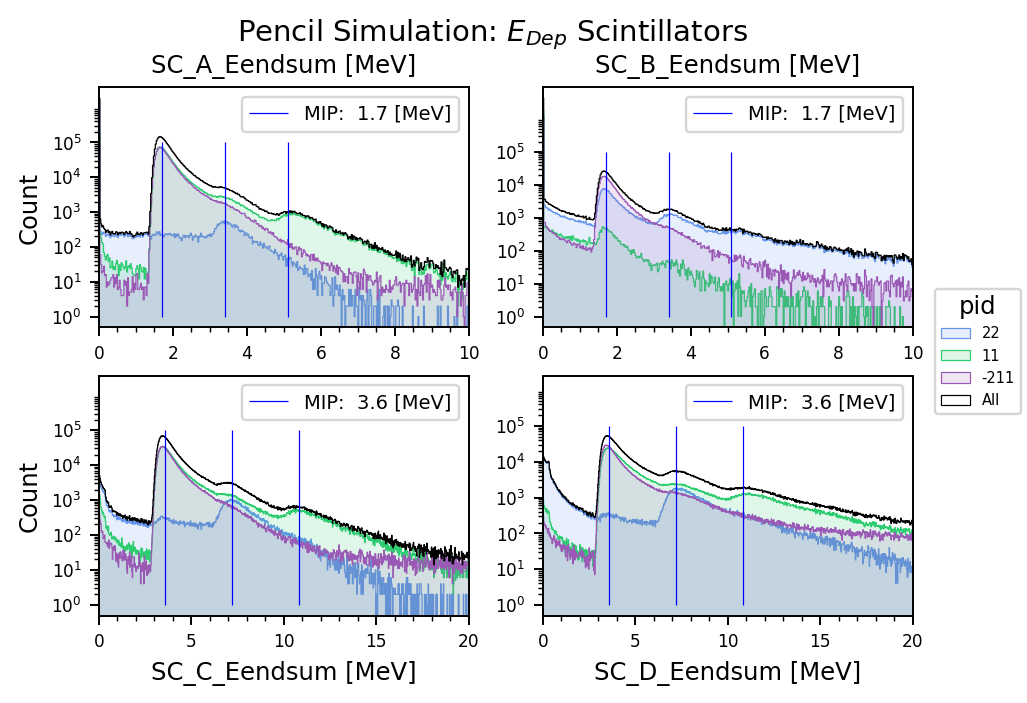

In [72]:
#
sim_MIPs = [1.7, 1.7, 3.6, 3.6]

plot_sim = all_sim#[sim_df["Npesum"]>0]#(np.array(sim_df["SC_A_Eendsum"]>0, dtype=int) + np.array(sim_df["SC_B_Eendsum"]>0, dtype=int) 
                   #+ np.array(sim_df["SC_C_Eendsum"]>0, dtype=int) + np.array(sim_df["SC_D_Eendsum"]>0, dtype=int)) >= 2]

plot_cols = ["SC_A_Eendsum","SC_B_Eendsum","SC_C_Eendsum","SC_D_Eendsum"]

limits = [10,10,20,20]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Pencil Simulation: $E_{Dep}$ Scintillators")

for i in range(4):
    

    sns.histplot(plot_sim, x= plot_cols[i],  hue="pid", binwidth=0.025, element="step", palette=sns.color_palette(best_colors[:-1]), 
                 #weights="rate",
                 alpha=0.15, linewidth=0.5, ax=axes[int(i/2),i%2], legend=0)
    
    sns.histplot(plot_sim, x=plot_cols[i],  binwidth=0.025, element="step", color="black", 
                 #weights="rate",
                 alpha=0, linewidth=0.5, ax=axes[int(i/2),i%2], legend=0)
    
    axes[int(i/2),i%2].vlines(np.array([1,2,3])*(sim_MIPs[i]*1.00), 1, 10**5, 
                              label=f"MIP: {sim_MIPs[i]*1.00: .1f} [MeV]", linewidths=.5, color="blue")
    axes[int(i/2),i%2].legend(prop={"size":8})
    
    #plt.legend()

    axes[int(i/2),i%2].set_yscale("log")
    
    axes[int(i/2),i%2].set_xticks(np.arange(0,limits[i],1), minor=1)
    
    #axes[int(i/2),i%2].set_xlabel("")
    
    
    #Axis Labels
    if i in [0,2]: axes[int(i/2),i%2].set_ylabel(f"Count")
    elif i in [1,3]: axes[int(i/2),i%2].set_ylabel("")
    
    if i in [0,1]: 
        axes[int(i/2),i%2].set_title(f"{plot_cols[i]} [MeV]", fontsize=10)
        axes[int(i/2),i%2].set_xlabel("")
    elif i in [2,3]: 
        axes[int(i/2),i%2].set_title(f"")
        axes[int(i/2),i%2].set_xlabel(f"{plot_cols[i]} [MeV]", fontsize=10)
        
    axes[int(i/2),i%2].set_xlim(0,limits[i])
    #axes[int(j/2),j%2].set_xticks(np.arange(0,51,10))
    axes[int(i/2),i%2].set_xticks(np.arange(0,limits[i],.5*(1+int(i/2))), minor=1)
    
    axes[int(i/2),i%2].set_yticks(10**np.arange(6))
    axes[int(i/2),i%2].set_yticks(np.tile(np.arange(1,10),6) * 10**np.repeat(np.arange(6),9), minor=1)

    axes[int(i/2),i%2].tick_params(axis="both", which="major", labelsize=7)
        
fig.legend(title='pid', loc=7, labels=[22,11,-211,"All"], prop={"size":6})
#plt.tight_layout()   
#plt.savefig(f"Plots/NewCher_SimScintillator.pdf")
plt.savefig("Plots/ForReport/FullPencil_Scints_TID1.pdf")
plt.show()

## GEM

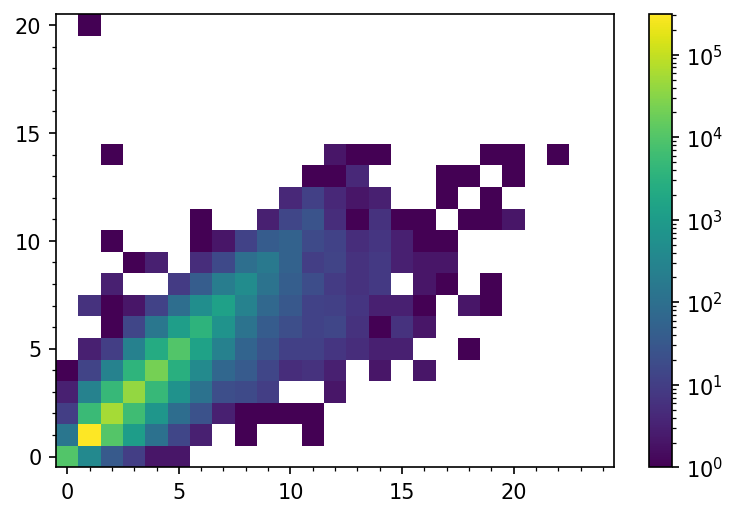

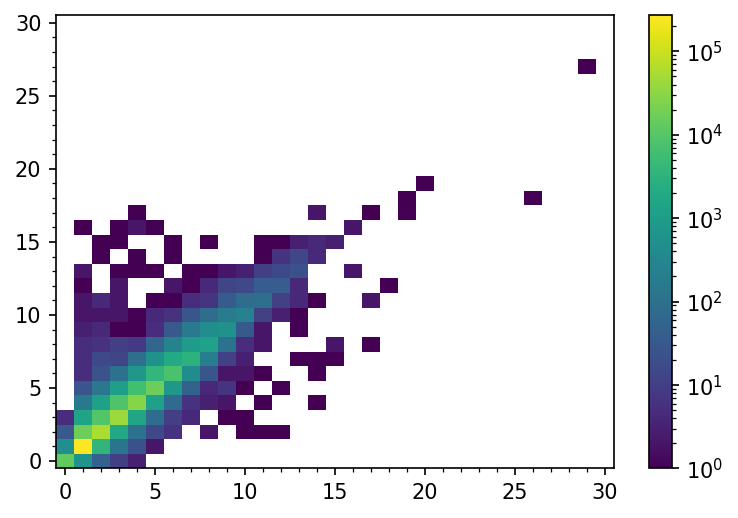

In [12]:
plt.figure(dpi=150)

plt.hist2d(sim_df["GEM00_n"], sim_df["GEM01_n"], norm=LogNorm(), bins=[np.arange(-1,25,1)+0.5,np.arange(-1,21,1)+0.5]
           #range=((0,13),(0,10))
          )

plt.xticks(np.arange(0,25,1), minor=1)
plt.yticks(np.arange(0,21,5))
plt.yticks(np.arange(0,21,1), minor=1)

plt.colorbar()
plt.show()

plt.figure(dpi=150)

plt.hist2d(sim_df["GEM10_n"], sim_df["GEM11_n"], norm=LogNorm(), bins=[np.arange(-1,31,1)+0.5,np.arange(-1,31,1)+0.5], 
           #range=((0,13),(0,10))
          )

plt.xticks(np.arange(0,31,1), minor=1)
plt.yticks(np.arange(0,31,1), minor=1)

plt.colorbar()
plt.show()

In [ ]:
%%time

GEM00_X = [np.mean(x) for x in sim_df["GEM00_vx"]]
GEM00_X

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


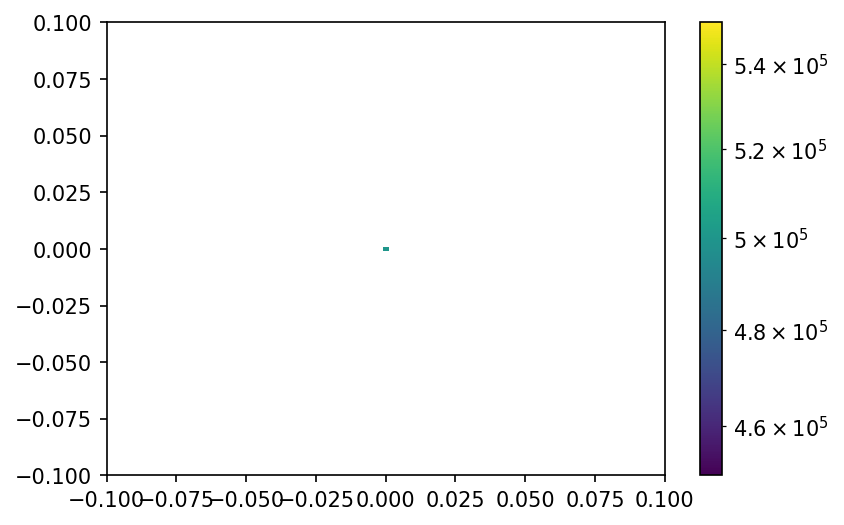

In [16]:
plt.figure(dpi=150)

plt.hist2d(sim_df["vx"], sim_df["vy"], norm=LogNorm(), bins=[np.linspace(-.1,.1,100),np.linspace(-.1,.1,100)]
           #range=((0,13),(0,10))
          )

"""plt.xticks(np.arange(0,25,1), minor=1)
plt.yticks(np.arange(0,21,5))
plt.yticks(np.arange(0,21,1), minor=1)"""

plt.colorbar()
plt.show()


In [14]:
sim_df.columns

Index(['rate', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'p', 'pid', 'PreShP',
       'PreShP_e', 'PreShPx', 'PreShPy', 'PreShPz', 'PreShtheta', 'PreShSum',
       'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l', 'Shower_r',
       'Shower_t', 'SC_A_P', 'SC_A_Eendsum', 'SC_A_Eend', 'SC_D_P',
       'SC_D_Eendsum', 'SC_D_Eend', 'SC_C_P', 'SC_C_Eendsum', 'SC_C_Eend',
       'SC_B_P', 'SC_B_Eendsum', 'SC_B_Eend', 'SPD_P', 'SPD_Eendsum',
       'SPD_Eend', 'LASPD_P', 'LASPD_Eendsum', 'LASPD_Eend', 'GEM00_n',
       'GEM00_np', 'GEM00_x', 'GEM00_y', 'GEM00_vy', 'GEM00_vx', 'GEM00_Edep',
       'GEM00_Edep2', 'GEM00_Edep3', 'GEM00_Etot', 'GEM10_n', 'GEM10_np',
       'GEM10_x', 'GEM10_y', 'GEM10_vy', 'GEM10_vx', 'GEM10_Edep',
       'GEM10_Edep2', 'GEM10_Edep3', 'GEM10_Etot', 'GEM01_n', 'GEM01_np',
       'GEM01_x', 'GEM01_y', 'GEM01_vy', 'GEM01_vx', 'GEM01_Edep',
       'GEM01_Edep2', 'GEM01_Edep3', 'GEM01_Etot', 'GEM11_n', 'GEM11_np',
       'GEM11_x', 'GEM11_y', 'GEM11_vy', 'GEM11_vx',

In [13]:
sim_df["GEM00_x"]

1271445                                [0.12066655606031418]
1291198           [-0.5998276472091675, -0.4670591652393341]
3040514                            [-1.1215219274163246e-05]
1664542          [0.02737444080412388, -0.03783119469881058]
718312     [0.2051692008972168, 0.2063513845205307, 0.986...
                                 ...                        
4035089                                  [3.278167486190796]
1954273                            [-1.1215219274163246e-05]
3810076                                [-0.5392010807991028]
3270677                            [-1.1215219274163246e-05]
2857708                            [-1.1215219274163246e-05]
Name: GEM00_x, Length: 500000, dtype: object

## Cherenkov

In [6]:
np.array(np.array(sim_df["Cer"]).sum())#.sum()

array([  55192.,  274829.,  275400.,   55671.,  273513., 1493666.,
       1497937.,  277213.,  275531., 1505948., 1506716.,  277241.,
         57669.,  275979.,  276876.,   57702.], dtype=float32)

In [7]:
sim_df["Npesum"].sum()

8437083.0

In [8]:
np.array(sim_df["Cer"])#.shape()

array([<cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x559243c6b3f0>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x559243c6b4b0>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x559243c6b570>, ...,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x55924984d150>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x55924984d210>,
       <cppyy.gbl.ROOT.VecOps.RVec<float> object at 0x55924984d2d0>],
      dtype=object)

In [80]:
(all_sim[keeps])[["rate","pid"]].groupby("pid").count()

,rate
pid,
-211,144158
11,163246
22,3833


In [93]:
(((((all_sim[keeps]["p"]-all_sim[keeps]["SC_B_P"]/1e3)/all_sim[keeps]["p"])[(keeps) & (all_sim["pid"]==11)] < .1).sum())/
 (all_sim["pid"][keeps]==11).sum())

0.0

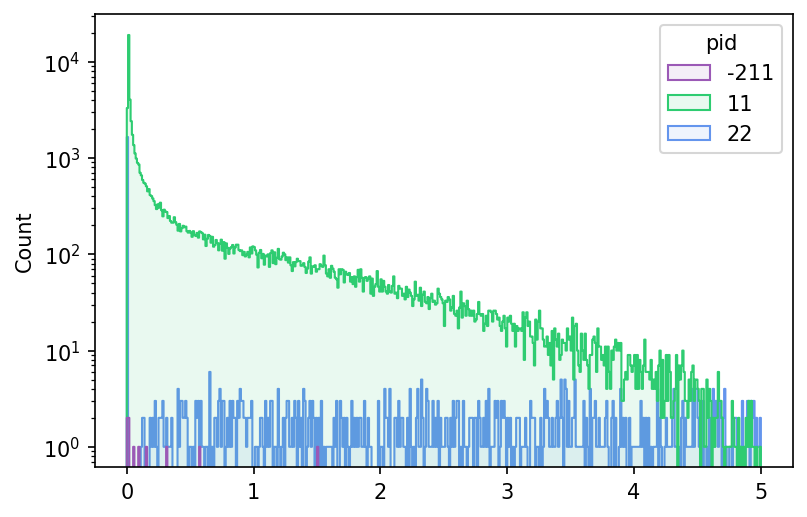

In [154]:
fig = plt.figure(dpi=150)

Scint_MIPs = [1.65, 3.5, 3.5, 1.65] # A, D, C, B
TS3_req = ((sim_df["SC_A_Eendsum"]>Scint_MIPs[0]/2) & (sim_df["SC_D_Eendsum"]>Scint_MIPs[1]/2) & (sim_df["ShowerSum"]>.5))

keeps = (all_sim["Npesum"]>20) & (all_sim["p"]<5) #TS3_req
sns.histplot(all_sim[keeps], x=(all_sim[keeps]["p"]-all_sim[keeps]["SC_A_P"]/1e3),#/all_sim[keeps]["p"],
             hue="pid", binwidth=.01, element="step", legend=1,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.1)
plt.yscale("log")
#fig.legend(title='pid', labels=[22,11,-211], prop={"size":8})


In [167]:
%%time

sum_val = 0

for i in range(int(1e3)):
    if i%1e3==0: print(i, end=" ")
    for j in range(int(2e5)):
        sum_val += i+j
print(sum_val)

0 20099800000000
CPU times: user 20.3 s, sys: 101 ms, total: 20.4 s
Wall time: 20.3 s


In [168]:
%%time

sum_val = 0

for i in range(int(1e3)):
    #if i%1e3==0: print(i, end=" ")
    test = np.column_stack([int(2e5)*[i], np.arange(2e5)])
    sum_val += test.sum()
print(sum_val)    

0 20099800000000.0
CPU times: user 11.2 s, sys: 46.6 ms, total: 11.2 s
Wall time: 11.2 s


In [169]:
%%time

sum_val = 0

for i in range(int(1e3)):
    #if i%1e3==0: print(i, end=" ")
    sum_val += np.column_stack([np.repeat(i,2e5), np.arange(2e5)]).sum()
print(sum_val)

20099800000000.0
CPU times: user 1.06 s, sys: 6.41 ms, total: 1.07 s
Wall time: 1.06 s


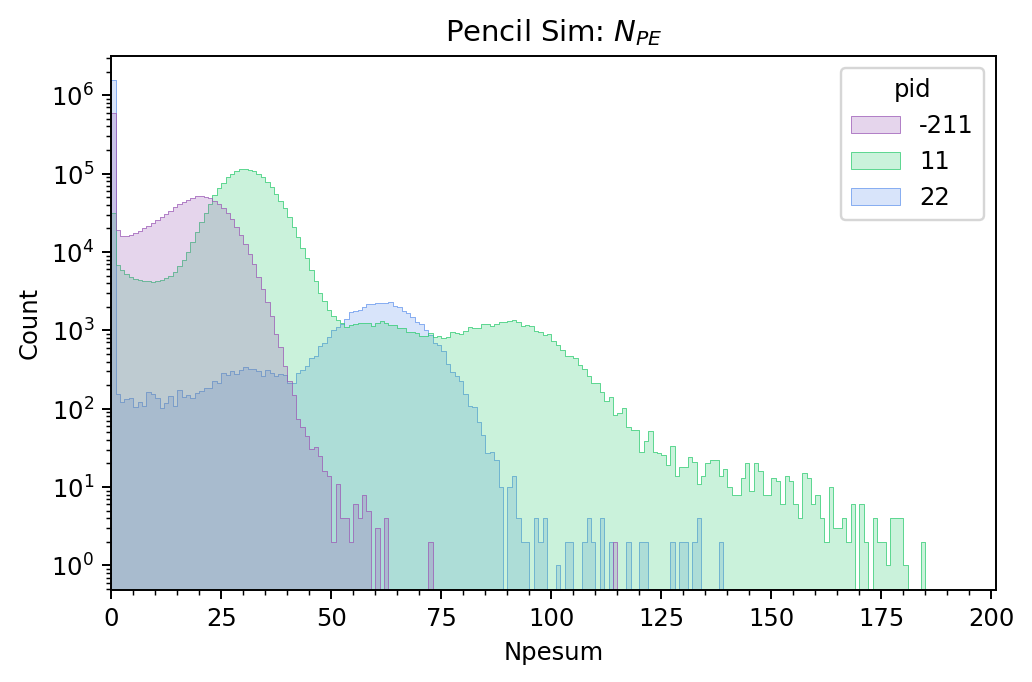

In [74]:
fig = plt.figure(dpi=175)
plt.title("Pencil Sim: $N_{PE}$")

all_sim = sim_df

plot_sim = sim_df#[(((all_sim["p"]-all_sim["SC_A_P"]/1e3)/all_sim["p"]) < .1) 
                 #& (((all_sim["p"]-all_sim["SC_A_P"]/1e3)/all_sim["p"]) == 1)
                 #]

sns.histplot(plot_sim[plot_sim["SC_A_P"]>-.10], x="Npesum", hue="pid", binwidth=1, element="step", legend=1,
             palette=sns.color_palette(best_colors[:-1]), alpha=0.25, linewidth=0.3)

#sns.histplot(bkg_Sim, x="Npesum", binwidth=1, element="step", 
#             color="red", alpha=0.05, linewidth=0.3)

#plt.vlines([20,31,62,93], 1,10**5)
plt.yscale("log")
plt.xlim(0,201)
plt.xticks(np.arange(0,201,5), minor=1)

#fig.legend(title='pid', labels=[22,11,-211,"Bkg"], prop={"size":10})

plt.tight_layout()
#plt.savefig("Plots/Pencil_NPE_TID1.pdf")
plt.savefig("Plots/ForReport/FullPencil_NPE_TID1.pdf")
plt.show()

In [27]:
all_sim.columns

Index(['rate', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'p', 'pid', 'PreShP',
       'PreShP_e', 'PreShPx', 'PreShPy', 'PreShPz', 'PreShtheta', 'PreShSum',
       'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l', 'Shower_r',
       'Shower_t', 'SC_A_P', 'SC_A_Eendsum', 'SC_A_Eend', 'SC_D_P',
       'SC_D_Eendsum', 'SC_D_Eend', 'SC_C_P', 'SC_C_Eendsum', 'SC_C_Eend',
       'SC_B_P', 'SC_B_Eendsum', 'SC_B_Eend', 'SPD_P', 'SPD_Eendsum',
       'SPD_Eend', 'LASPD_P', 'LASPD_Eendsum', 'LASPD_Eend', 'GEM00_n',
       'GEM00_np', 'GEM00_x', 'GEM00_y', 'GEM00_vy', 'GEM00_vx', 'GEM00_Edep',
       'GEM00_Edep2', 'GEM00_Edep3', 'GEM00_Etot', 'GEM10_n', 'GEM10_np',
       'GEM10_x', 'GEM10_y', 'GEM10_vy', 'GEM10_vx', 'GEM10_Edep',
       'GEM10_Edep2', 'GEM10_Edep3', 'GEM10_Etot', 'GEM01_n', 'GEM01_np',
       'GEM01_x', 'GEM01_y', 'GEM01_vy', 'GEM01_vx', 'GEM01_Edep',
       'GEM01_Edep2', 'GEM01_Edep3', 'GEM01_Etot', 'GEM11_n', 'GEM11_np',
       'GEM11_x', 'GEM11_y', 'GEM11_vy', 'GEM11_vx',

CPU times: user 4.64 s, sys: 2.07 s, total: 6.71 s
Wall time: 6.15 s


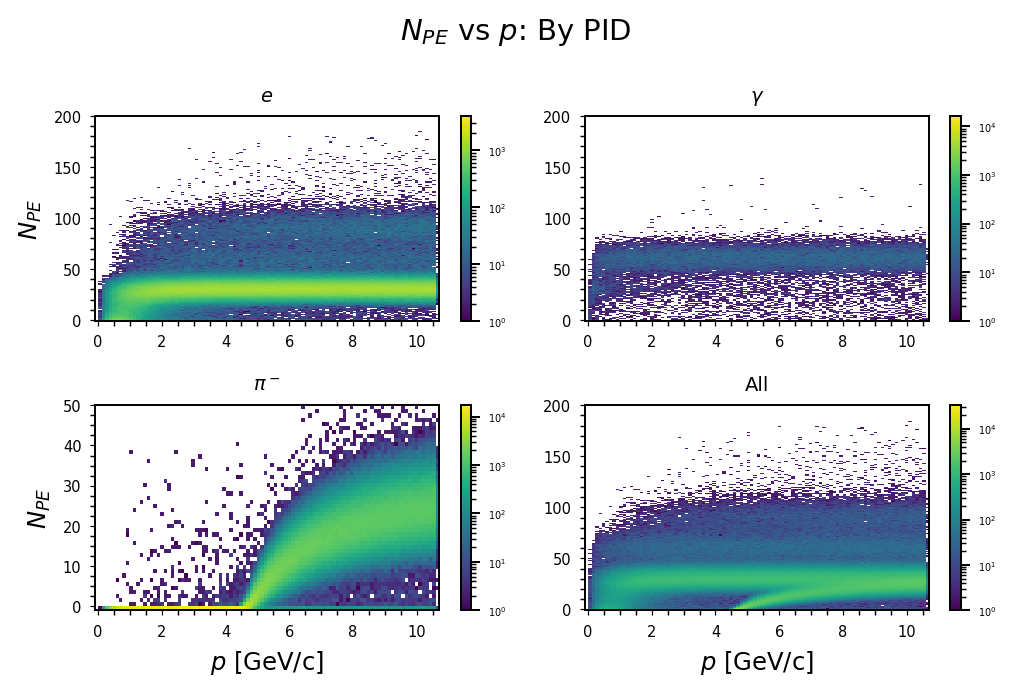

In [9]:
%%time

# Loop Over Shower Vals
columns =["p","Npesum"]
x_bin = [50, 5,5,5]

ylimits=[200,200,50,200]
y_ticks=[10,10,2.5,10]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)
sub_part = "{PE}"
fig.suptitle(f"$N_{sub_part}$ vs $p$: By PID")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"],#/1e3, 
                                                         plot_sim[f"{columns[1]}"], 
                                                         range=((-0.1,10.7),(-1,ylimits[j])),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,ylimits[j]], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel("$N_{PE}$",rotation=90)
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"${columns[0]}$ [GeV/c]")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,11,.5), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,ylimits[j],y_ticks[j]), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/Pencil_NPE_p_TID1.pdf")   #AngleCut


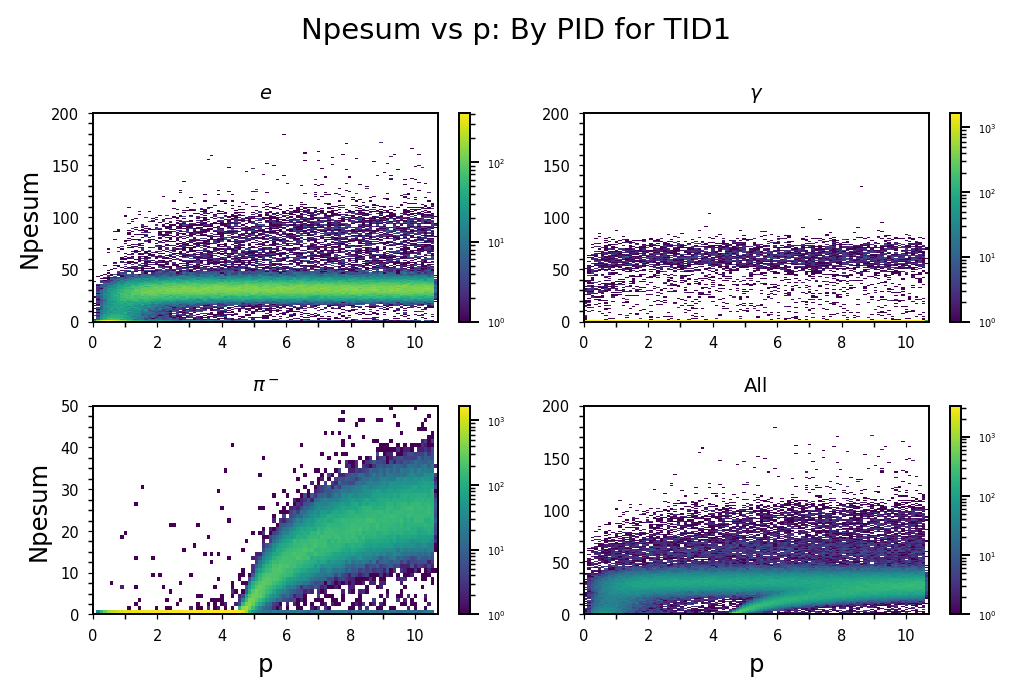

In [8]:
# Loop Over Shower Vals
columns =["p","Npesum"]
x_bin = [50, 5,5,5]

ylimits=[200,200,50,200]
y_ticks=[10,10,2.5,10]

all_sim = sim_df
pcuts = [[0.1,0.3], [0.3,0.5], [0.5,0.7], [0.7,0.9]]

particles = ["$e$", "$\gamma$", "$\pi^-$", "All"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("Npesum vs p: By PID for TID1")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8) #Angle, 
    
    if j!=3:
        plot_sim = all_sim[(all_sim["pid"]==part_ids[j])]
    
    else:
        plot_sim = all_sim#[(all_sim["pid"]==part_ids[j])]

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_sim[f"{columns[0]}"], plot_sim[f"{columns[1]}"], range=((0,10.7),(0,ylimits[j])),#limits[j], 
                                                         #weights=plot_sim["rate"],
                     bins=[100,ylimits[j]], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,11,1), minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,ylimits[j],y_ticks[j]), minor=1)    
    
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/Pencil_NPE_p_TID1.pdf")   #AngleCut


In [9]:
%%time

channel_list = [[] for _ in range(16)]
    
for row in all_sim["Cer"]:#[data0["TrigType"] == 32]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Cer_array = np.array(channel_list).T

CPU times: user 36.4 s, sys: 2.71 s, total: 39.1 s
Wall time: 39 s


### Channel Dists

In [42]:
len(Cer_array[:,0])

500000

CPU times: user 1min, sys: 18.6 s, total: 1min 18s
Wall time: 1min 17s


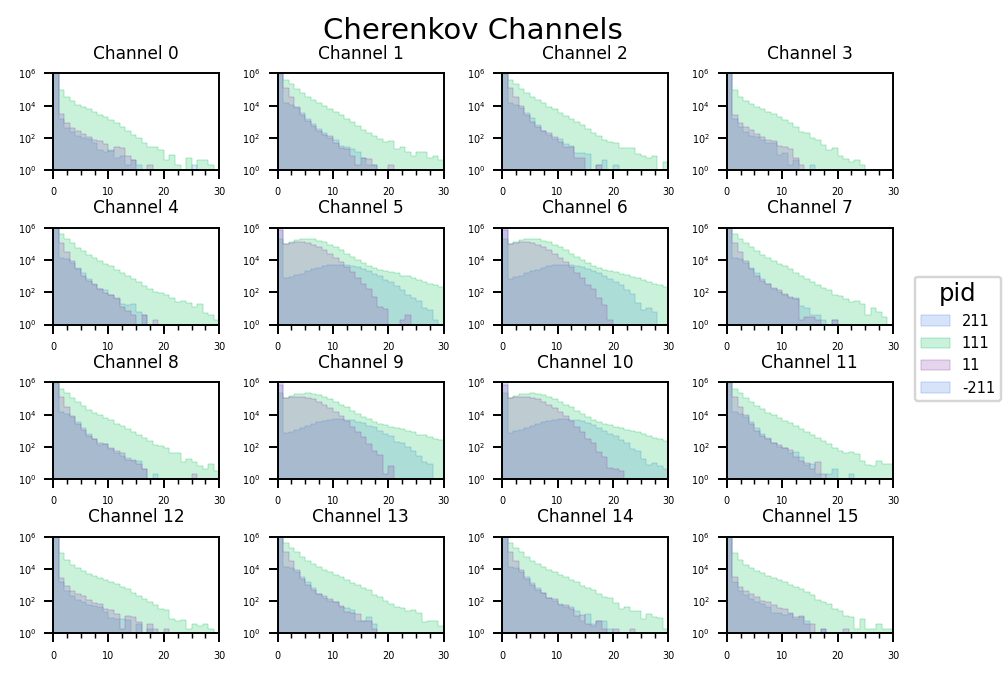

In [75]:
%%time

channel_order = [15,14,11,10,13,12,9,8,7,6,3,2,5,4,1,0]
#Make Plot

fig, axes = plt.subplots(4, 4, dpi=175)
keeps = (all_sim["Npesum"] > -1)

plot_data = all_sim
range_factor = 10

#By L, R, T, Sum
for j in range(4):
    for k in range(4):
        #Get Channel Num
        channel_num = j*4+k#channel_order[j*4+k]
               
        #Get Data
        axes[j,k].set_title(f"Channel {channel_num}", fontsize=7)
        loop_data = Cer_array[:,[channel_num]]
        
        sns.histplot(plot_data[keeps], x=(loop_data.flatten())[keeps], hue="pid", binwidth=1, 
                     element="step", linewidth=.15, palette=sns.color_palette(best_colors[:-1]), 
                     alpha=0.25, ax=axes[j,k], legend=0)
        #Axis Formatting
        axes[j,k].set_xlim(0,30)
        axes[j,k].set_xticks(np.arange(0,30,2.5), minor=1)
        axes[j,k].set_ylim(1, 10**5+1)
        axes[j,k].set_yticks(10**np.arange(0,7), minor=1)

        #Formatting                            
        axes[j,k].set_yscale("log")
        axes[j,k].set_xlabel("")
        axes[j,k].set_ylabel("")
        axes[j,k].tick_params(axis="both", which="major", labelsize=4)
        axes[j,k].tick_params(axis="both", which="minor", labelsize=1)


#Figure Formatting
fig.suptitle(f"Cherenkov Channels")
fig.legend(title='pid', loc=7, labels=[211,111,11,-211], prop={"size":6})

#Output Formatting
#plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.35, hspace=0.6)
#plt.savefig(f"Plots/NewCher_CherenkovChannels.pdf")
plt.savefig("Plots/ForReport/FullPencil_CherenkovChannels_TID1.pdf")
#plt.show()

### N_Ch vs NPE

CPU times: user 4.72 s, sys: 2.32 s, total: 7.04 s
Wall time: 4.59 s


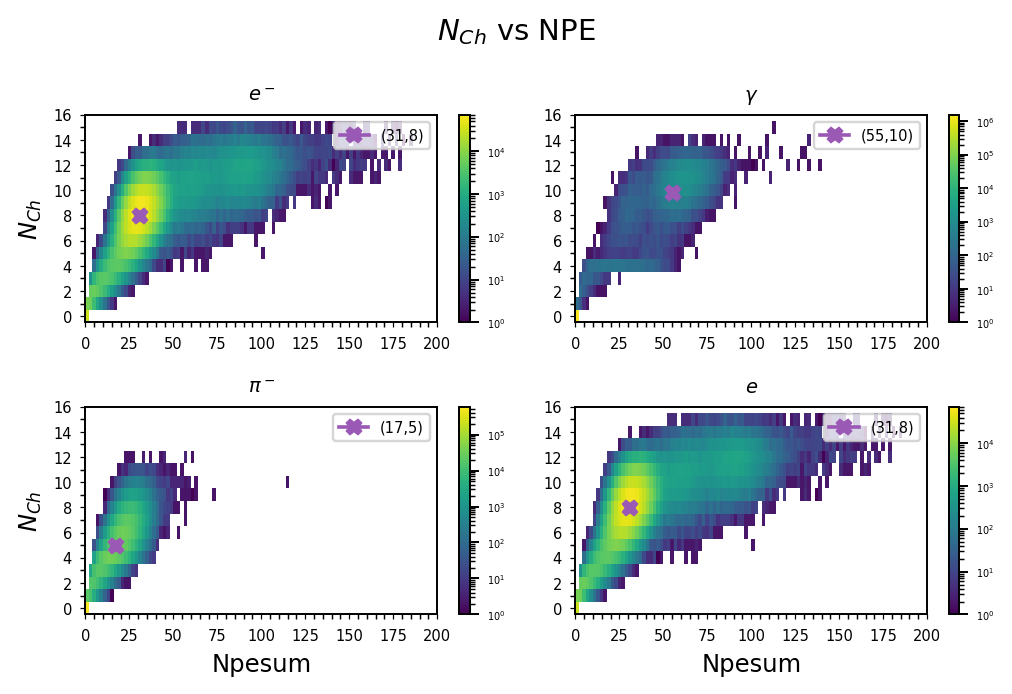

In [76]:
%%time 

# Loop Over Shower Vals
columns =["Npesum","$N_{Ch}$"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,600),(0,150)],[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,100)]]
bins = [[60,15], [30,8], [60,12], [30,8]]


particles = ["$e^-$", "$\gamma$", "$\pi^-$", "$e$"]#np.unique(new_sim_df["pid"])
part_ids = [11, 22, -211, 11]

p_scaling = 1

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("$N_{Ch}$ vs NPE")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8)
    
    keeps = (all_sim["pid"]==part_ids[j])

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(all_sim["Npesum"][keeps], (Cer_array>0).sum(axis=1)[keeps],
                                                         #weights="rate",
                                                         #bins=[np.arange(0,bins[j][0],1),np.arange(0.5,bins[j][1]+.5,1)], 
                                                         bins=[np.arange(0,201,2),np.arange(-0.5,16.5,1)], norm=LogNorm())
    #Blob centers
    mu_NPE = np.mean(all_sim["Npesum"][(keeps) & (all_sim["Npesum"]>0)])
    mu_NCh = np.mean((Cer_array>0).sum(axis=1)[(keeps) & (all_sim["Npesum"]>0)])
    axes[int(j/2),j%2].plot(mu_NPE, mu_NCh, marker="X", label=f"({mu_NPE:.0f},{mu_NCh:.0f})")
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    axes[int(j/2),j%2].legend(fontsize=6)
    
    #Scaling Line
    x = np.arange(0,60,1)
    #axes[int(j/2),j%2].plot(x,x)
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,201,5),minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,16.1,2))
    axes[int(j/2),j%2].set_yticks(np.arange(0,16.1,1),minor=1)
    #axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
#plt.savefig(f"Plots/NewCher_NCh_NPE.pdf") 
plt.savefig("Plots/ForReport/FullPencil_NCh_NPE_TID1.pdf")

### Heatmap

In [31]:
sim_df["Cer"]#[0]

1271445    [0.0, 1.0, 5.0, 0.0, 1.0, 10.0, 5.0, 1.0, 0.0,...
1291198    [0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 6.0, 0.0, 2.0, ...
3040514    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1664542    [0.0, 1.0, 0.0, 0.0, 1.0, 6.0, 5.0, 0.0, 0.0, ...
718312     [0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 7.0, 0.0, 2.0, ...
                                 ...                        
4035089    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1954273    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3810076    [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, ...
3270677    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2857708    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Cer, Length: 500000, dtype: object

In [32]:
Cer_array

array([[0., 1., 5., ..., 0., 2., 0.],
       [0., 0., 0., ..., 1., 4., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 2., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

keeps = (all_sim["pid"]==11)&(sim_df["Shower_t"]>500)&(sim_df["Shower_l"]>500) 
channel_sums = (Cer_array[keeps]).sum(axis=0)*np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

np.rot90(channel_sums.reshape(4,4).astype(int))

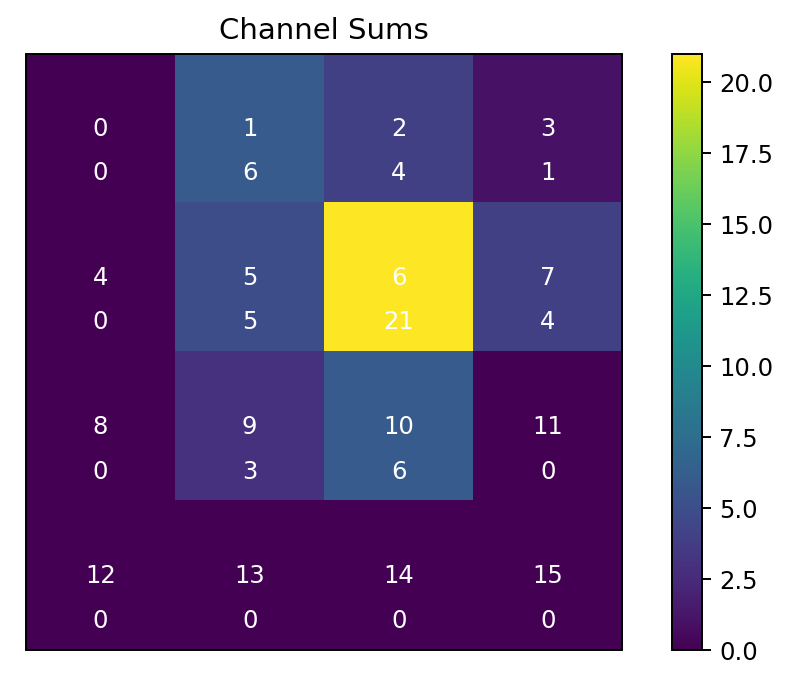

In [89]:
#Normalize Channels and Get Sums
keeps = (all_sim["pid"]==11)&(all_sim["NCh"]<9)&(all_sim["Npesum"]==50) #&(sim_df["Shower_t"]>500)&(sim_df["Shower_l"]>600) #& (sim_df["Shower_t"]>500) #(all_sim["pid"]==11)&(all_sim["Npesum"]>0) #

channel_sums = (Cer_array[keeps])[0]#.sum(axis=0)*np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) #Cer_array[keeps][0]


#Labels
labels = [["D3","D2","C3","C2"],
          ["D1","D0","C1","C0"],
          ["B3","B2","A3","A2"],
          ["B1","B0","A1","A0"]]

order = np.arange(0,16,1) #[15,14,11,10,13,12,9,8,7,6,3,2,5,4,1,0]#

#Make Heatmap
fig, ax = plt.subplots(dpi=175)
plt.title("Channel Sums")
#plt.title("Normalized Sum Before Coincidence Cuts")
im = ax.imshow(np.rot90((channel_sums).reshape(4,4),k=1))#(((channel_sums).reshape((4, 4))).T)

ax.set_xticks([])
ax.set_yticks([])

for i in range(4):
    for j in range(4):
        text = ax.text(i, j, (np.arange(0,16,1).reshape((4, 4)).T)[i][j], ha="center", va="center", color="w") #labels[i][j]
        text = ax.text(i, j+.3, (np.rot90((channel_sums.reshape((4, 4)))).T).astype(int)[i][j], ha="center", va="center", color="w")

ax.figure.colorbar(im, ax=ax)
fig.tight_layout()
#plt.savefig(f"Plots/NewCher_ChannelHeatmap.pdf")
plt.show()


### Shower Center Cuts

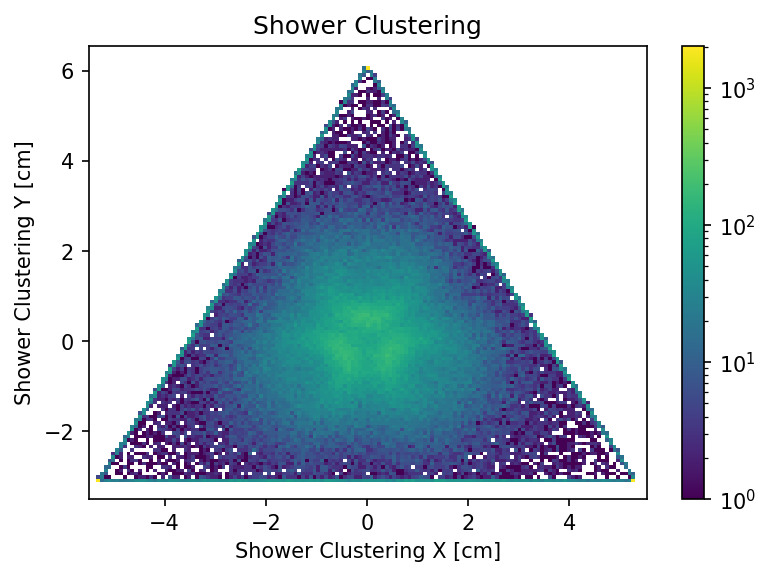

In [67]:
Clust_x, Clust_y, Clust_z = Shower_Clustering(all_sim["Shower_l"],all_sim["Shower_t"],all_sim["Shower_r"])

plt.figure(dpi=150)
plt.title("Shower Clustering")
plt.xlabel("Shower Clustering X [cm]")
plt.ylabel("Shower Clustering Y [cm]")

keeps = ((Clust_x**2 + Clust_y**2)**0.5 < 2000) & (all_sim["pid"]==11)

plt.hist2d(Clust_x[keeps], Clust_y[keeps], norm=LogNorm(), #weights=all_sim["rate"],
           bins=[np.arange(-5.5,5.6,.075),np.arange(-3.5,6.6,.075)])#, range=((-5.5,5.5),(-3.5,6.5)))

plt.colorbar()

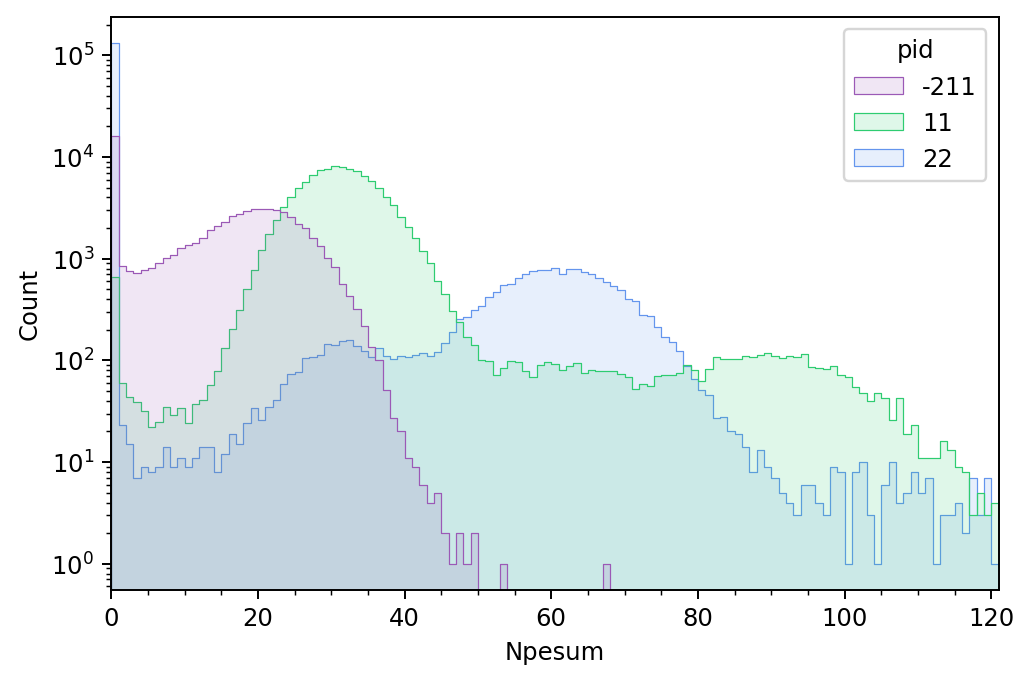

In [60]:
plt.figure(dpi=175)
#plot_sim = sim_df[sim_df["Npesum"]>0]

keeps = ((Clust_x**2 + Clust_y**2)**0.5 < 2)

sns.histplot(all_sim[keeps], x="Npesum", hue="pid", binwidth=1, element="step", #weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
plt.xlim(0,121)
plt.xticks(np.arange(0,121,5), minor=1)

plt.tight_layout()
plt.savefig("Plots/NewCher_NPE_CenterCut.pdf")
plt.show()

In [99]:
np.flip((np.arange(0,16)).reshape((4, 4)),axis=1).T

array([[ 3,  7, 11, 15],
       [ 2,  6, 10, 14],
       [ 1,  5,  9, 13],
       [ 0,  4,  8, 12]])

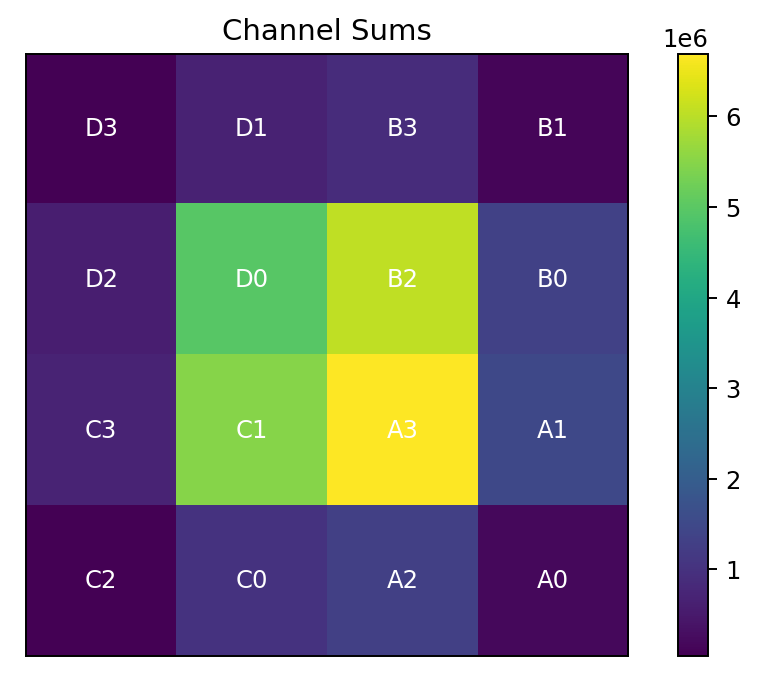

In [56]:
#Normalize Channels and Get Sums
keeps = (sim_df["Shower_r"]>20) & (sim_df["Shower_t"]>20) #(Clust_x>0) & (Clust_y<0)
#((Clust_x**2 + Clust_y**2)**0.5 < 1)#(sim_df["Shower_r"]>20) & (sim_df["Shower_t"]>20)

channel_sums = ((Cer_array)[keeps]).sum(axis=0)*np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])


#Labels
labels = [["D3","D2","C3","C2"],
          ["D1","D0","C1","C0"],
          ["B3","B2","A3","A2"],
          ["B1","B0","A1","A0"]]

order = np.arange(0,16,1)#[15,14,11,10,13,12,9,8,7,6,3,2,5,4,1,0]

#Make Heatmap
fig, ax = plt.subplots(dpi=175)
plt.title("Channel Sums")
#plt.title("Normalized Sum Before Coincidence Cuts")
im = ax.imshow(np.flip((channel_sums).reshape((4, 4)),axis=1).T)

ax.set_xticks([])
ax.set_yticks([])

for i in range(4):
    for j in range(4):
        text = ax.text(i, j, labels[i][j], ha="center", va="center", color="w") #labels[i][j]
        #text = ax.text(i, j, np.arange(0,16,1)[order].reshape((4, 4))[i][j], ha="center", va="center", color="w")
        

ax.figure.colorbar(im, ax=ax)
fig.tight_layout()
plt.savefig(f"Plots/NewCher_ChannelHeatmap_Cuts.pdf")
plt.show()


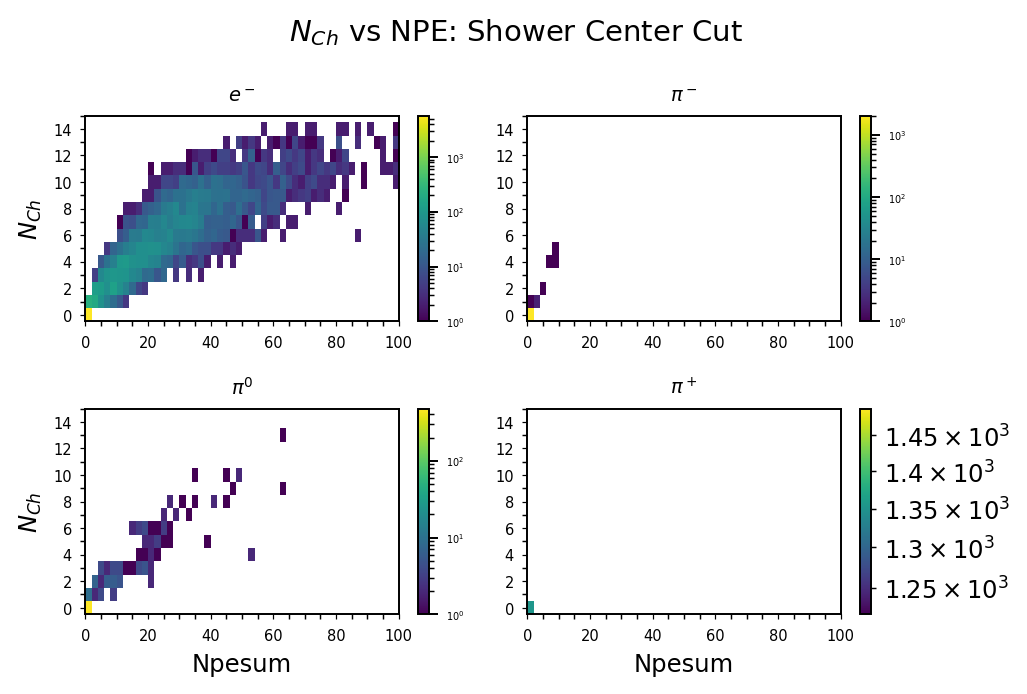

In [101]:
# Loop Over Shower Vals
columns =["Npesum","$N_{Ch}$"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,600),(0,150)],[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,100)]]
bins = [[60,15], [30,8], [60,12], [30,8]]


particles = ["$e^-$", "$\pi^-$", "$\pi^0$", "$\pi^+$"]
part_ids = [11, -211, 111, 211]

fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("$N_{Ch}$ vs NPE: Shower Center Cut")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8)
    
    keeps = (all_sim["pid"]==part_ids[j]) & ((Clust_x**2 + Clust_y**2)**0.5 < 1)

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(all_sim["Npesum"][keeps], (Cer_array>0).sum(axis=1)[keeps],
                                                         #bins=[np.arange(0,bins[j][0],1),np.arange(0.5,bins[j][1]+.5,1)], 
                                                         bins=[np.arange(0,101,2),np.arange(-0.5,15.5,1)], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    x = np.arange(0,60,1)
    #axes[int(j/2),j%2].plot(x,x)
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,101,5),minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,16,2))
    axes[int(j/2),j%2].set_yticks(np.arange(0,16,1),minor=1)
    #axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/NewCher_NCh_NPE_CenterCut.pdf") 


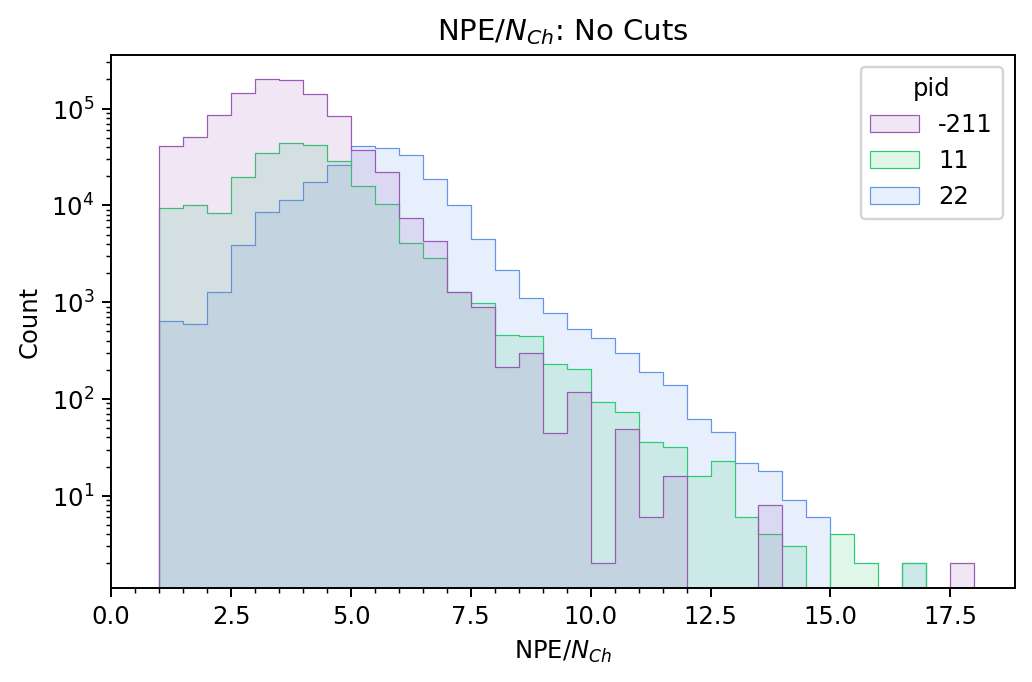

In [57]:
plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: No Cuts")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")

keeps = (all_sim["Npesum"]>0) & ((all_sim["ShowerSum"]<200) | (all_sim["pid"]!=11)) #& ((Clust_x**2 + Clust_y**2)**0.5 < 2)

all_sim["NPE_NCh"] = all_sim["Npesum"]/((Cer_array>0).sum(axis=1)+0.0001)

sns.histplot(all_sim[keeps], x="NPE_NCh", hue="pid", binwidth=.5, element="step", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
#plt.savefig(f"Plots/NewCher_NPE_Per_NCh_NoCuts.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

### Cherenkov Position

In [269]:
((Cher_Array_4x4*x_points)/Cher_Sums[:,None,None]).std(axis=(2,1))

<ipython-input-269-4ccb3f2ee802>:1: RuntimeWarning: invalid value encountered in true_divide
  ((Cher_Array_4x4*x_points)/Cher_Sums[:,None,None]).std(axis=(2,1))


array([0.07094092, 0.06817524,        nan, ..., 0.06865875,        nan,
              nan])

In [69]:
%%time
Cher_Array_4x4 = np.rot90(Cer_array.reshape(len(Cer_array),4,4),axes=(1,2))
Cher_Sums = Cer_array.sum(axis=1)
Cher_Sigmas = Cer_array.std(axis=1)

x_points = np.rot90(np.tile(np.arange(-1.5,1.6,1), (4,1)).T)
Cher_X = (Cher_Array_4x4*x_points).sum(axis=(2,1))/Cher_Sums
Cher_dX = ((Cher_Array_4x4*x_points)).std(axis=(2,1))/Cher_Sigmas

y_points = np.rot90(np.tile(np.arange(-1.5,1.6,1), (4,1)))
Cher_Y = (Cher_Array_4x4*y_points).sum(axis=(2,1))/Cher_Sums
Cher_dY = ((Cher_Array_4x4*y_points)).std(axis=(2,1))/Cher_Sigmas

<timed exec>:6: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:7: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:10: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:11: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 150 ms, sys: 90.7 ms, total: 241 ms
Wall time: 237 ms


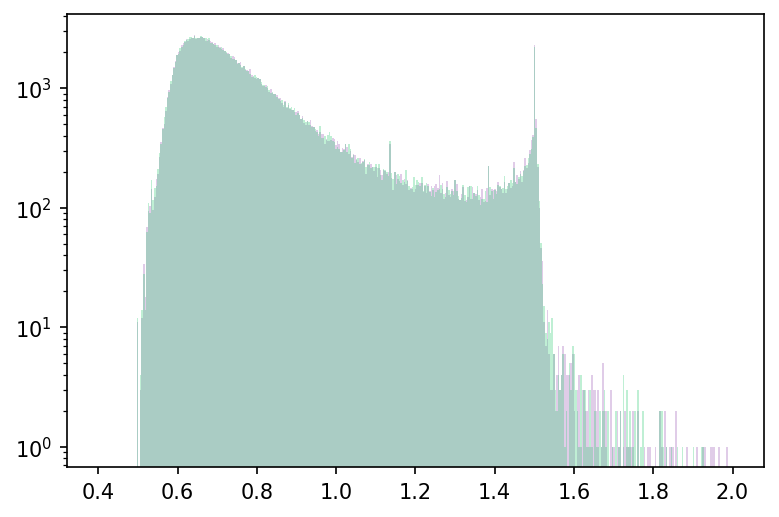

In [70]:
plt.figure(dpi=150)
keeps = (all_sim["pid"]==11) & (all_sim["Npesum"]>0) & (all_sim["NCh"]>1) #& (all_sim["Npesum"]<35)

plt.hist(Cher_dX[keeps], bins=np.linspace(0.4,2,400), 
         alpha=0.3)
plt.hist(Cher_dY[keeps], bins=np.linspace(0.4,2,400), 
         alpha=0.3)
plt.yscale("log")
plt.show()

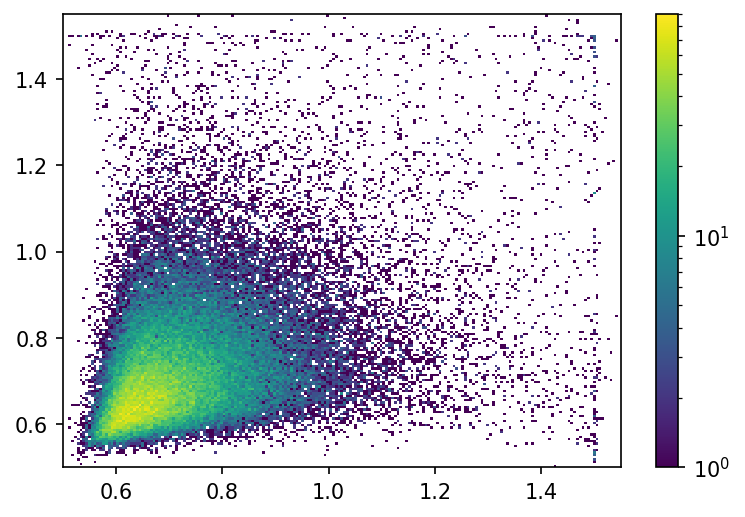

In [75]:
plt.figure(dpi=150)

keeps = (all_sim["pid"]==11) & (all_sim["Npesum"]>0) & (all_sim["NCh"]>1) & ((all_sim["p"]>6)&(all_sim["p"]<40)) 
#& (all_sim["Npesum"]>25) & (all_sim["Npesum"]<35)

plt.hist2d(Cher_dX[keeps], Cher_dY[keeps], 
           bins=(np.linspace(0.5,1.55,200),np.linspace(0.5,1.55,200)),  
           norm=LogNorm())

plt.colorbar()
#Cher_dY)

In [184]:
np.rot90(Cer_array[0].reshape(4,4))

array([[ 0.,  1.,  2.,  0.],
       [ 5.,  5.,  3.,  2.],
       [ 1., 10.,  7.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [185]:
np.rot90(Cer_array.reshape(len(Cer_array),4,4),axes=(1,2))[0]

array([[ 0.,  1.,  2.,  0.],
       [ 5.,  5.,  3.,  2.],
       [ 1., 10.,  7.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [151]:
x, y = np.tile(np.arange(-1.5,1.6,1), (4,1)).T.flatten(), np.tile(np.arange(-1.5,1.6,1), (4,1)).flatten()

Cher_x, Cher_y = ((x*Cer_array).sum(axis=1))/(Cer_array.sum(axis=1)+1e-5), ((y*Cer_array).sum(axis=1))/(Cer_array.sum(axis=1)+1e-5)

In [105]:
np.vstack((Cher_x, Cher_y)).T

array([[ 1.2999974 ,  1.499997  ],
       [ 0.        ,  0.        ],
       [-0.80434748, -1.28260814],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

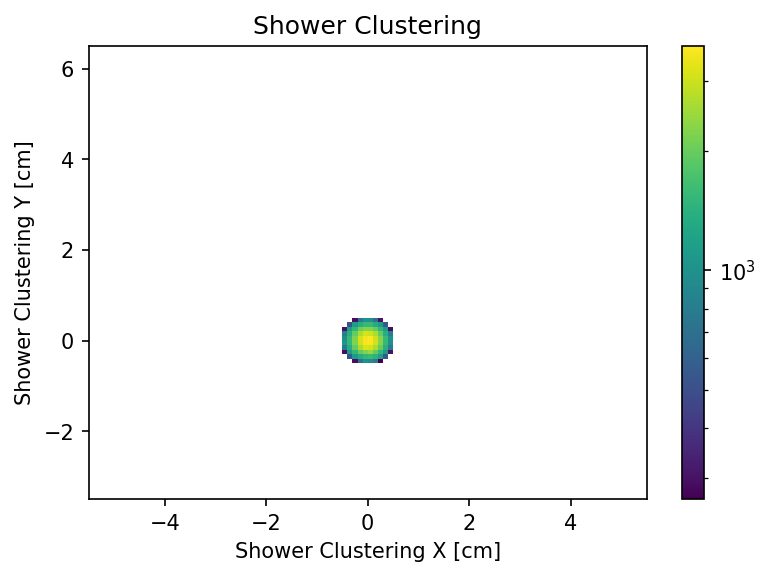

In [225]:
Clust_x, Clust_y, Clust_z = Shower_Clustering(all_sim["Shower_l"],all_sim["Shower_t"],all_sim["Shower_r"])

plt.figure(dpi=150)
plt.title("Shower Clustering")
plt.xlabel("Shower Clustering X [cm]")
plt.ylabel("Shower Clustering Y [cm]")

keeps = ((Clust_x**2 + Clust_y**2)**0.5 < .5)

plt.hist2d(Clust_x[keeps], Clust_y[keeps], norm=LogNorm(), #weights=all_sim["rate"],
           bins=[np.arange(-5.5,5.6,.1),np.arange(-3.5,6.6,.1)])#, range=((-5.5,5.5),(-3.5,6.5)))

plt.colorbar()

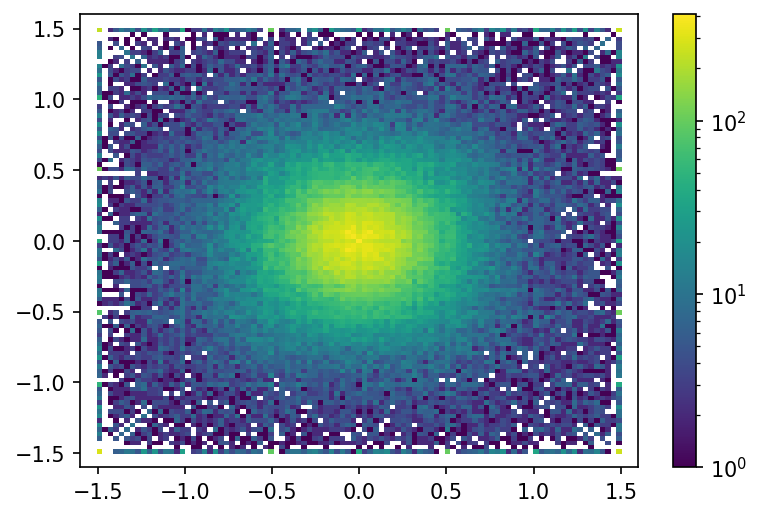

In [320]:
fig, ax = plt.subplots(dpi=150)

keeps = (all_sim["pid"]==11) & (all_sim["Npesum"]>0) #& (((Clust_x-1)**2 + (Clust_y-1)**2)**0.5 < .5)

plt.hist2d(Cher_x[keeps], Cher_y[keeps], norm=LogNorm(), bins=np.linspace(-1.6,1.6,102))
center = plt.Circle((0.2,.2),.5, fill=0, color="cornflowerblue", lw=2)
#ax.add_patch(center)

plt.colorbar()

In [ ]:
### plt.figure(dpi=150)

plt.scatter()


In [34]:
Cer_array[2]

array([8., 1., 0., 0., 8., 4., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
Cer_array

array([[0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       [8., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Coincidence

In [76]:
def get_good_array(array):
    #All Combinations - Easier than something fancy
    combos = [[0,1,3,2],
              [1,0,4,6,3,2],
              [2,0,1,3,9,8],
              [3,2,0,1,4,6,12,9,8],
              [4,1,5,7,6,3],
              [5,4,6,7],
              [6,3,1,4,7,5,13,12,9],
              [7,6,4,5,13,12],
              [8,2,3,9,11,10],
              [9,8,2,3,6,12,14,11,10],
              [10,8,9,11],
              [11,10,8,9,12,14],
              [12,9,3,6,7,13,15,14,11],
              [13,12,6,7,15,14],
              [14,11,9,12,13,15],
              [15,14,12,13]]

    #Get Good Entries
    good_entries=[]
    
    #Loop Through Channels
    for n in range(len(combos)):
    #Needs True x At Least One Fired
        good_entries.append((array[:,combos[n][0]]*((array[:,combos[n][1:]].sum(axis=1))>=1)))
    good_array = array*np.array(good_entries).T
    
    return good_array

def get_good_array_sim(array):
    #All Combinations - Easier than something fancy
    combos = [[0,4,1,5],
              [1,5,4,0,2,6],
              [2,6,5,1,3,7],
              [3,7,6,2],
              [4,8,0,1,5,9],
              [5,9,8,4,0,1,2,6,10],
              [6,10,9,5,1,2,3,7,11],
              [7,11,10,6,2,3],
              [8,12,4,5,9,13],
              [9,13,12,8,4,5,6,10,14],
              [10,14,13,9,5,6,7,11,15],
              [11,15,14,10,6,7],
              [12,8,9,13],
              [13,12,8,9,10,14],
              [14,13,9,10,11,15],
              [15,14,10,11]]

    #Get Good Entries
    good_entries=[]
    
    #Loop Through Channels
    for n in range(len(combos)):
    #Needs True x At Least One Fired
        good_entries.append((array[:,combos[n][0]]*((array[:,combos[n][1:]].sum(axis=1))>=1)))
    good_array = array*np.array(good_entries).T
    
    return good_array



<ipython-input-79-5b8c84acb75c>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(plot_data[(plot_data["Num_Ch"]>=0) & (plot_data["Num_Ch"]<=3) & (keeps)], x="New_NPE", hue="Num_Ch", element="step",


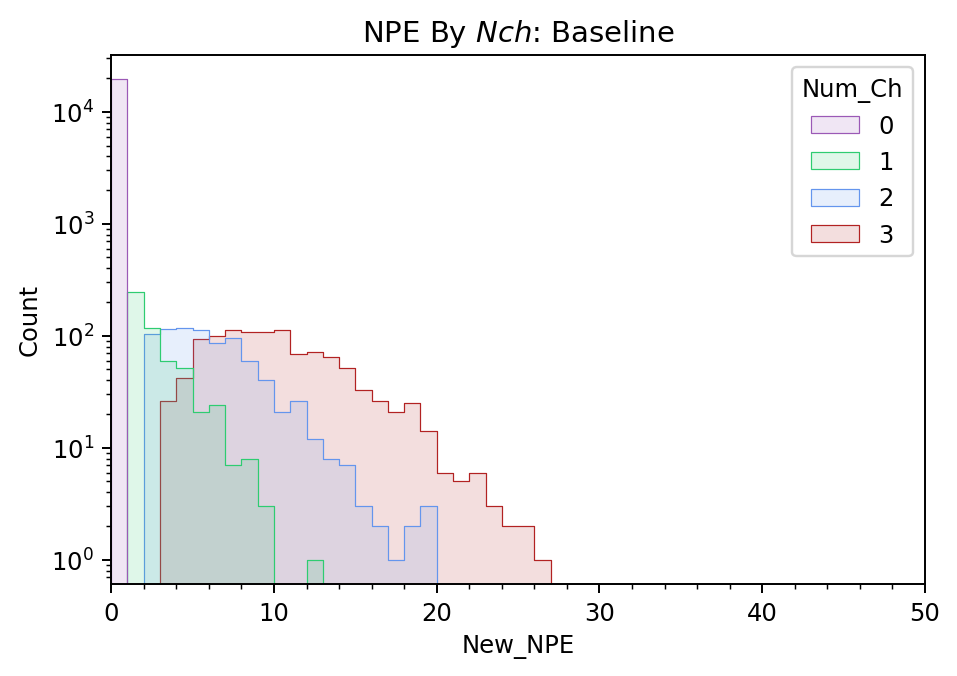

<ipython-input-79-5b8c84acb75c>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(plot_data[(plot_data["Num_Ch"]>=4) & (plot_data["Num_Ch"]<=7) & (keeps)], x="New_NPE", hue="Num_Ch", element="step",


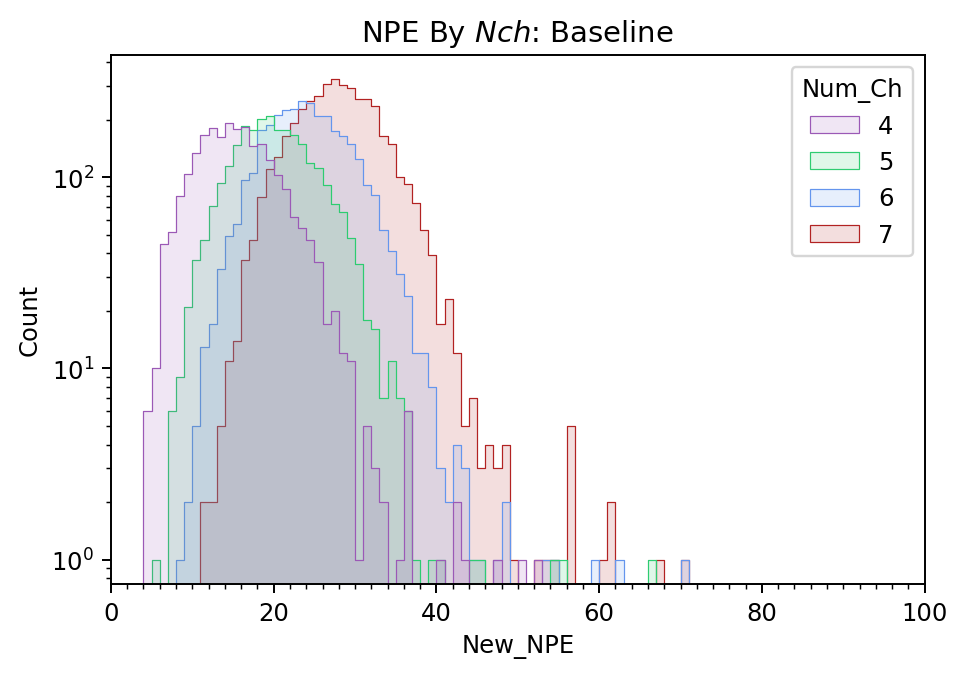

<ipython-input-79-5b8c84acb75c>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(plot_data[(plot_data["Num_Ch"]>=8) & (plot_data["Num_Ch"]<=11) & (keeps)], x="New_NPE", hue="Num_Ch", element="step",


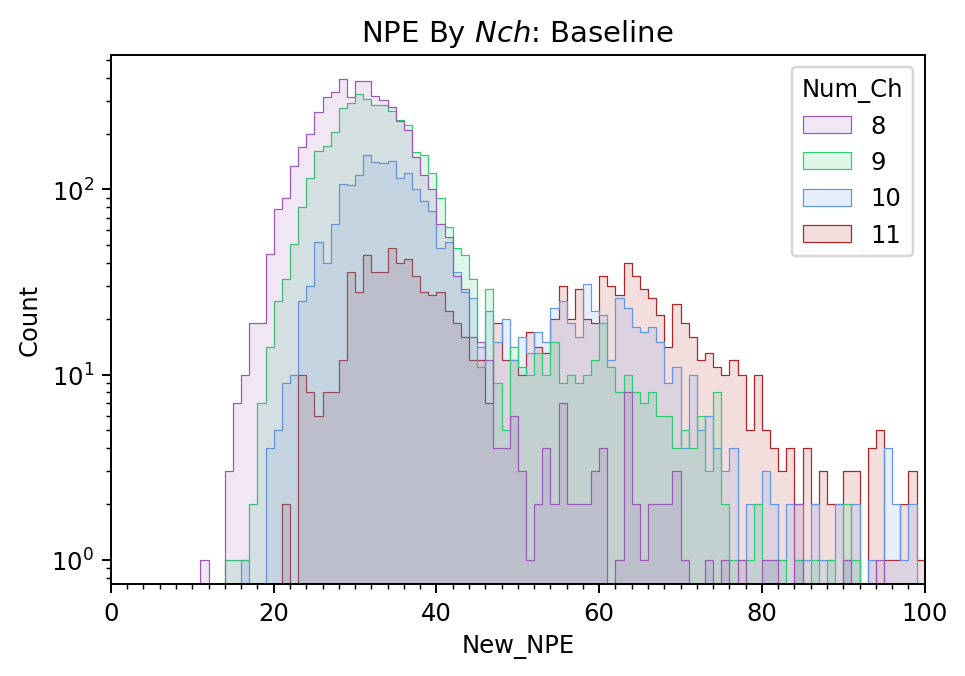

<ipython-input-79-5b8c84acb75c>:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(plot_data[(plot_data["Num_Ch"]>=12) & (plot_data["Num_Ch"]<=15) & (keeps)], x="New_NPE", hue="Num_Ch", element="step",


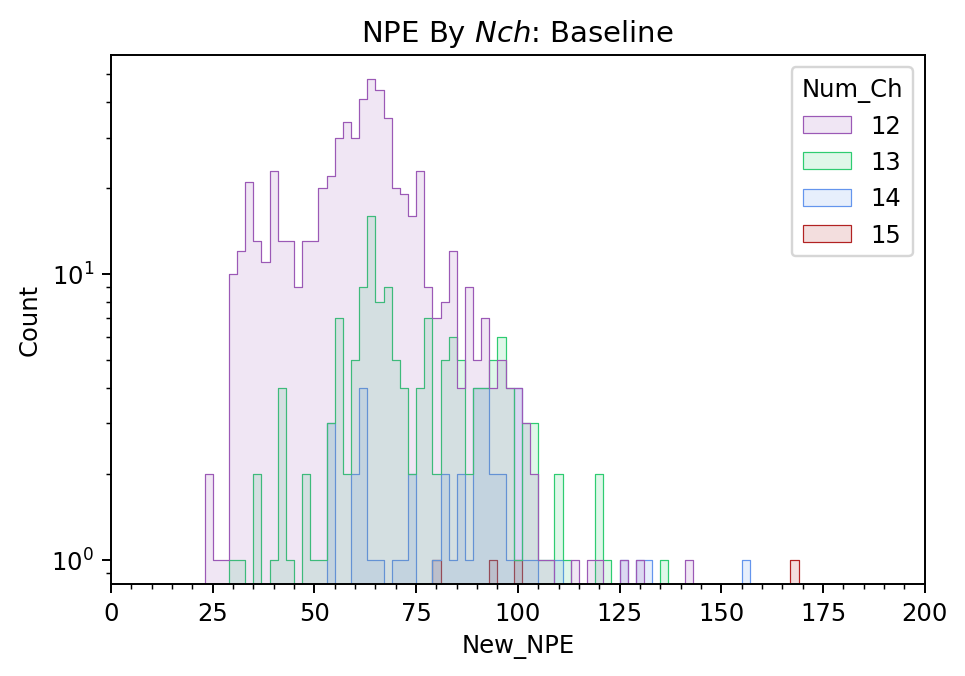

In [79]:
#triggers = [8,4,1]
#keeps = np.isin(raw_data_df["TrigType"],triggers)

#Scale & Get Keeps
channel_bool_val = (Cer_array > 0) 
keeps = (sim_df["pid"]==11)

plot_data = pd.DataFrame({'New_NPE':((Cer_array)).sum(axis=1).flatten(), 
                          'Num_Ch':(Cer_array>0).sum(axis=1)})

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=0) & (plot_data["Num_Ch"]<=3) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.15, linewidth=0.5)
plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,50+1,2), minor=True)

plt.savefig(f"Plots/NewCher_NPE_ByChannel.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=4) & (plot_data["Num_Ch"]<=7) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.15, linewidth=0.5)
plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,100+1,2), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=8) & (plot_data["Num_Ch"]<=11) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.15, linewidth=0.5)
plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,100+1,2), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Baseline")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=12) & (plot_data["Num_Ch"]<=15) & (keeps)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=2, alpha=0.15, linewidth=0.5)
plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,200+1,5), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()


In [37]:
best_colors[0:1]+best_colors[2:]

['#9b59b6', '#2ecc71', 'cornflowerblue', 'firebrick']

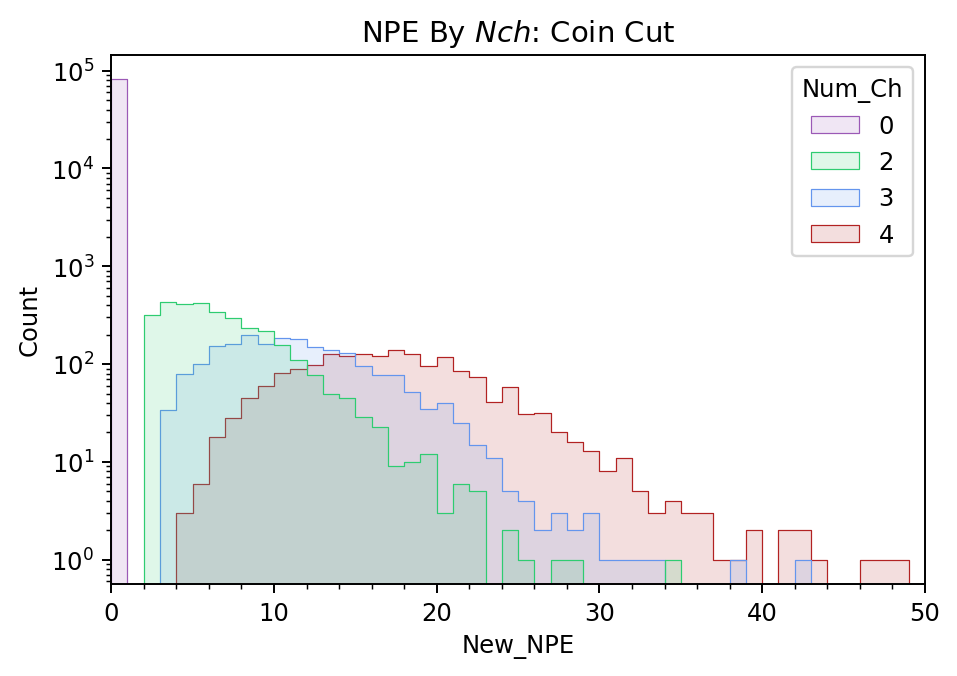

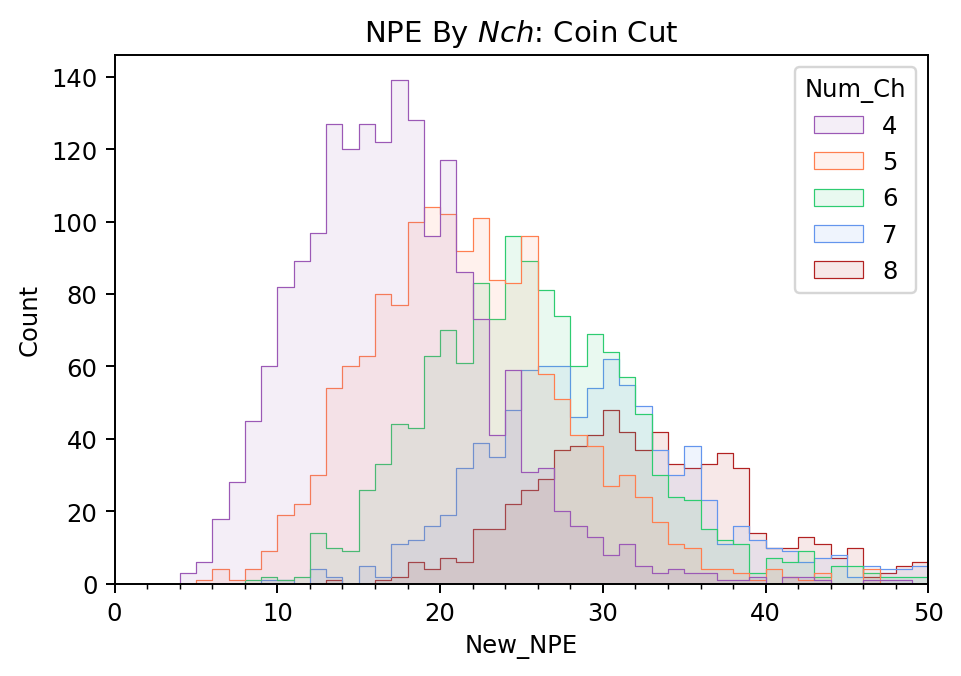

In [38]:
#triggers = [8,4,1]
#keeps = np.isin(raw_data_df["TrigType"],triggers)

#Scale & Get Keeps
channel_bool_val = (Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1)})

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Coin Cut")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=-1) & (plot_data["Num_Ch"]<=4)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors[0:1]+best_colors[2:]), 
             binwidth=1, alpha=0.15, linewidth=0.5)
plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,50+1,2), minor=True)

plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()

plt.figure(dpi=175)
plt.title(f"NPE By $Nch$: Coin Cut")
sns.histplot(plot_data[(plot_data["Num_Ch"]>=4) & (plot_data["Num_Ch"]<=8)], x="New_NPE", hue="Num_Ch", element="step", 
             palette=sns.color_palette(best_colors), 
             binwidth=1, alpha=0.1, linewidth=0.5)
#plt.yscale("log")
plt.xlim(0,50)
plt.xticks(np.arange(0,50+1,2), minor=True)

#plt.savefig(f"Plots/NewCher_NPE_ByChannel_Coin.pdf")
plt.show()


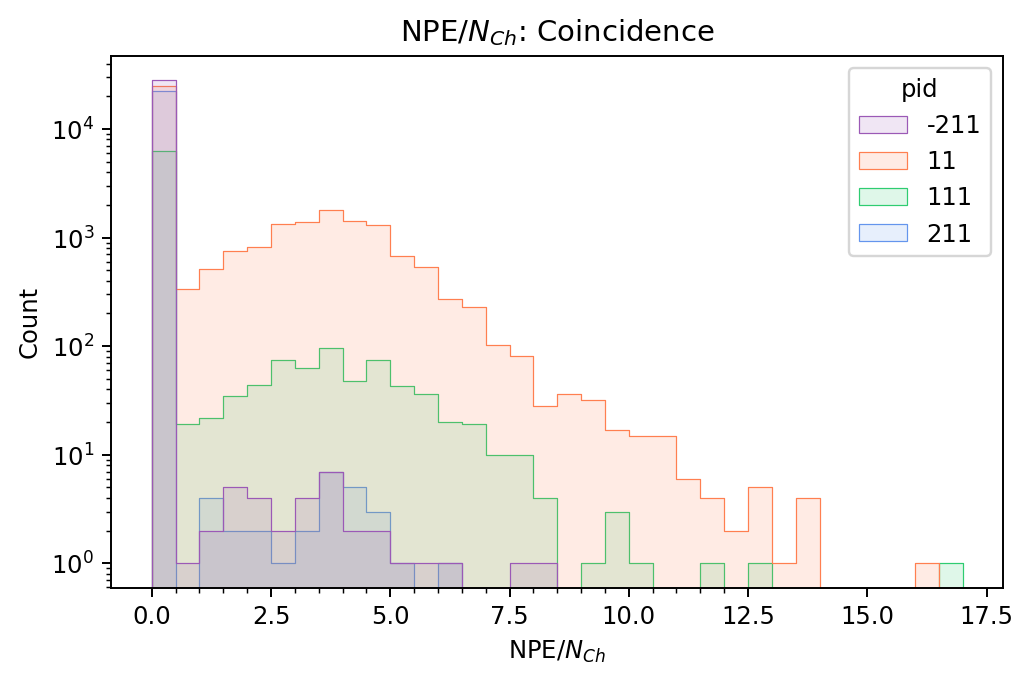

In [43]:
plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: Coincidence")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")

channel_bool_val = (Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1),
                          'pid':sim_df["pid"]})

plot_data["NPE_NCh"] = plot_data["New_NPE"]/(plot_data["Num_Ch"]+0.0001)

keeps = (sim_df["ShowerSum"]>-200)

sns.histplot(plot_data[keeps], x="NPE_NCh", hue="pid", binwidth=.5, element="step", 
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
plt.savefig(f"Plots/NewCher_NPE_Per_NCh_Coin.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

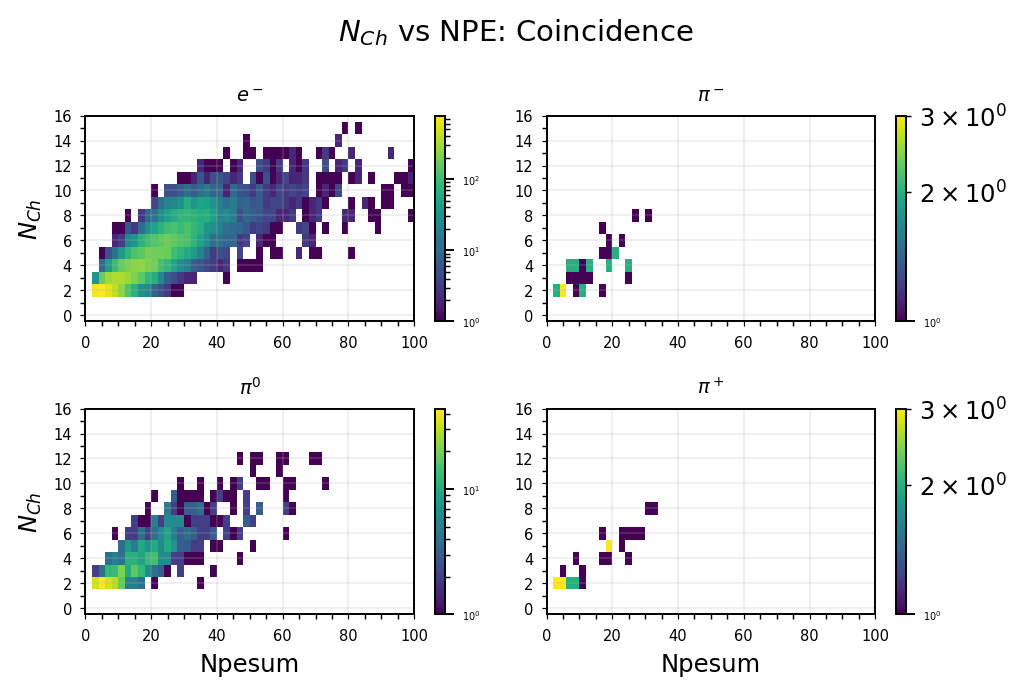

In [44]:
# Loop Over Shower Vals
columns =["Npesum","$N_{Ch}$"]
#bin_nums = [150,150,150,125,150]
limits = [[(0,600),(0,150)],[(0,150),(0,100)],[(0,150),(0,100)],[(0,150),(0,100)]]
bins = [[60,15], [30,8], [60,12], [30,8]]


particles = ["$e^-$", "$\pi^-$", "$\pi^0$", "$\pi^+$"]
part_ids = [11, -211, 111, 211]

p_scaling = 1


channel_bool_val = (Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1),
                          'pid':sim_df["pid"]})



fig, axes = plt.subplots(2, 2, dpi=175)    
fig.suptitle("$N_{Ch}$ vs NPE: Coincidence")

#Loop through Triggers
for j in range(4): 
    axes[int(j/2),j%2].set_title(f"{particles[j]}", fontsize=8)
    
    keeps = (plot_data["pid"]==part_ids[j]) & (plot_data["New_NPE"]>0) #& ((sim_df["ShowerSum"]>200) | (plot_data["pid"]!=11)) #HE electron cut

    h, xedges, yedges, image = axes[int(j/2),j%2].hist2d(plot_data["New_NPE"][keeps], plot_data["Num_Ch"][keeps],
                                                         #bins=[np.arange(0,bins[j][0],1),np.arange(0.5,bins[j][1]+.5,1)], 
                                                         bins=[np.arange(0,101,2),np.arange(-0.5,16.5,1)], norm=LogNorm())
    
    cbar = plt.colorbar(image, ax=axes[int(j/2),j%2])
    cbar.ax.tick_params(labelsize=4)
    
    #Scaling Line
    x = np.arange(0,60,1)
    #axes[int(j/2),j%2].plot(x,x)
    #axes[int(j/2),j%2].legend(framealpha=1, prop={"size":6})
    
    #Axis Labels
    if j in [0,2]:
        axes[int(j/2),j%2].set_ylabel(f"{columns[1]}")
    if j in [2,3]:
        axes[int(j/2),j%2].set_xlabel(f"{columns[0]}")
    
    #Tick Params
    axes[int(j/2),j%2].set_xticks(np.arange(0,101,5),minor=1)
    axes[int(j/2),j%2].set_yticks(np.arange(0,17,2))
    axes[int(j/2),j%2].set_yticks(np.arange(0,17,1),minor=1)
    #axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    axes[int(j/2),j%2].tick_params(labelsize=6, length=2, width=0.5)
    
    axes[int(j/2),j%2].grid(alpha=0.2)
    
plt.tight_layout()#pad=0.2)
plt.savefig(f"Plots/NewCher_NCh_NPE_Coin.pdf") 


## Pseudo-Triggers

In [15]:
#MIP Peak Values
Scint_MIPs = [1.65, 1.65, 3.5, 3.5]
Shower_MIP = 37.5#[37.5,37.5,37.5,37.5]

#Assuming SC-threshold @ half-MIP to start, then will get more precise values later

#TS1 - CherSum
TS1_Sim = all_sim[all_sim["Npesum"]>=2].copy()
TS1_Sim["Trig"] = "TS1"

#TS2 - SC-B & SC-D
TS2_Sim = all_sim[(all_sim["SC_B_Eendsum"]>Scint_MIPs[1]/2) & (all_sim["SC_D_Eendsum"]>Scint_MIPs[3]/2)].copy()
TS2_Sim["Trig"] = "TS2"

#TS3 - SC-C & SC-D & ShowerSum (ShSum val is an estimate)
TS3_Sim = all_sim[(all_sim["SC_C_Eendsum"]>Scint_MIPs[2]/2) & (all_sim["SC_D_Eendsum"]>Scint_MIPs[3]/2) & (all_sim["ShowerSum"]>15)].copy()
TS3_Sim["Trig"] = "TS3"

#TS4 - ShowerSum 
TS4_Sim = all_sim[all_sim["ShowerSum"]>200].copy()
TS4_Sim["Trig"] = "TS4"

#Combine
Trig_Sim = TS1_Sim.append([TS2_Sim,TS3_Sim,TS4_Sim])
Trig_Sim

,rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM11_vx,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,Cer,theta,NCh,Trig
0,0.000261,0.212364,0.047032,4.135960,-0.875710,0.006042,2.66734,2.807420,11,0.000000,...,[],0.000000,0.000000,0.000000,0.000000,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.175845,2,TS1
2,0.000370,-0.128510,-0.117401,0.500567,-0.574820,-0.002970,1.78003,1.870544,11,1830.968872,...,"[-670.5233764648438, -670.750244140625, -675.0...",0.002258,0.002258,0.002258,0.031919,23.0,"[8.0, 1.0, 0.0, 0.0, 8.0, 4.0, 0.0, 0.0, 2.0, ...",17.896899,5,TS1
4,0.000190,0.036881,0.068365,-3.156610,-1.254460,-0.000594,3.88418,4.081730,11,4071.276611,...,"[-670.0872802734375, -669.8561401367188]",0.000967,0.000967,0.000967,0.020122,29.0,"[0.0, 4.0, 11.0, 2.0, 0.0, 5.0, 6.0, 1.0, 0.0,...",17.898709,6,TS1
5,0.000190,-0.179174,0.113327,-2.168040,-1.264350,0.009848,3.92927,4.127692,11,0.000000,...,[-671.216064453125],0.000000,0.000000,0.000000,0.000000,12.0,"[0.0, 0.0, 1.0, 11.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17.837515,2,TS1
13,0.000254,0.094947,0.005353,1.726020,-0.942165,0.008594,2.89119,3.040843,11,0.000000,...,[-671.0243530273438],0.000000,0.000000,0.000000,0.000000,7.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, ...",18.050168,2,TS1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43313,2.096245,0.066167,-0.040340,-0.716216,-0.829929,-0.003734,2.55594,2.687308,-211,2681.831787,...,"[-673.3743286132812, -669.8782958984375]",0.019789,0.019789,0.019789,5.771978,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.989096,0,TS4
43420,2.095492,-0.092468,0.196380,-3.208640,-0.802055,-0.000241,2.49484,2.620595,-211,2616.338623,...,[-668.0147094726562],0.000057,0.000057,0.000057,0.112972,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.821844,0,TS4
43878,2.098754,0.119042,0.189024,-2.803890,-1.137980,-0.009401,3.50945,3.689353,-211,0.000000,...,[],0.000000,0.000000,0.000000,0.000000,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17.966457,0,TS4
44936,2.092417,-0.111480,0.039445,2.154820,-0.587686,0.000497,1.80266,1.896037,-211,1892.355225,...,[-674.717529296875],0.014658,0.014658,0.014658,0.096409,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18.056515,0,TS4


(-32.37425994873047, 700.0)

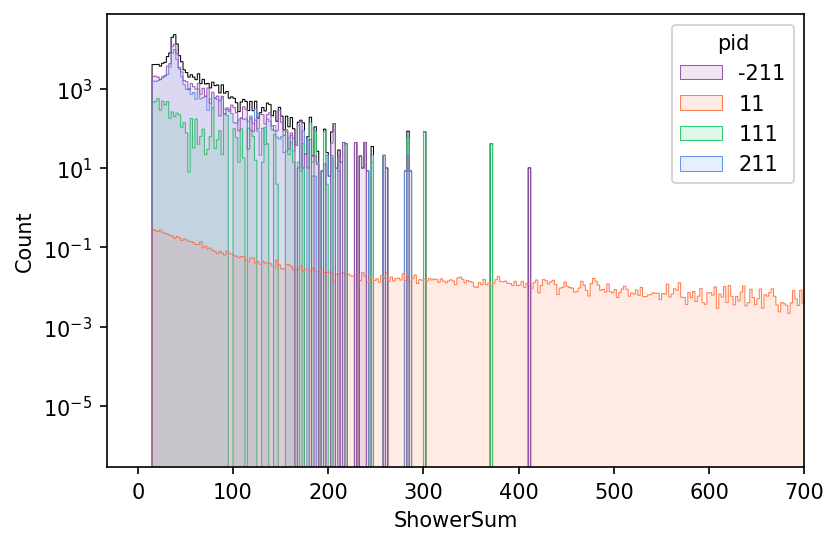

In [24]:
plt.figure(dpi=150)
sns.histplot(TS3_Sim, x="ShowerSum", binwidth=2.5, element="step", weights="rate", 
             alpha=0, linewidth=0.5, color="black")

sns.histplot(TS3_Sim, x="ShowerSum", hue="pid", binwidth=2.5, element="step", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
plt.xlim(right=700)

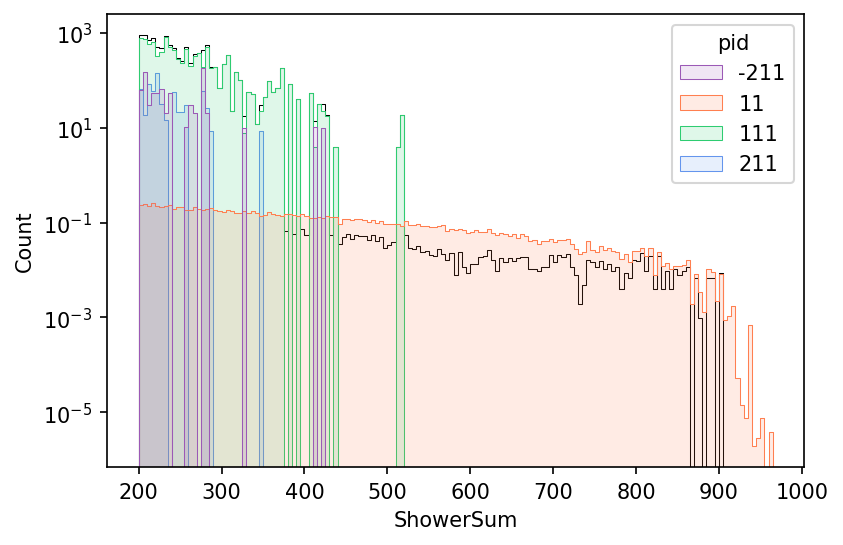

In [20]:
#TS4 - ShowerSum 
TS4_Sim = all_sim[all_sim["ShowerSum"]>200].copy()
TS4_Sim["Trig"] = "TS4"

plt.figure(dpi=150)
sns.histplot(TS4_Sim, x="ShowerSum", binwidth=5, element="step", #weights="rate", 
             alpha=0, linewidth=0.5, color="black")

sns.histplot(TS4_Sim, x="ShowerSum", hue="pid", binwidth=5, element="step", #weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(right=700)

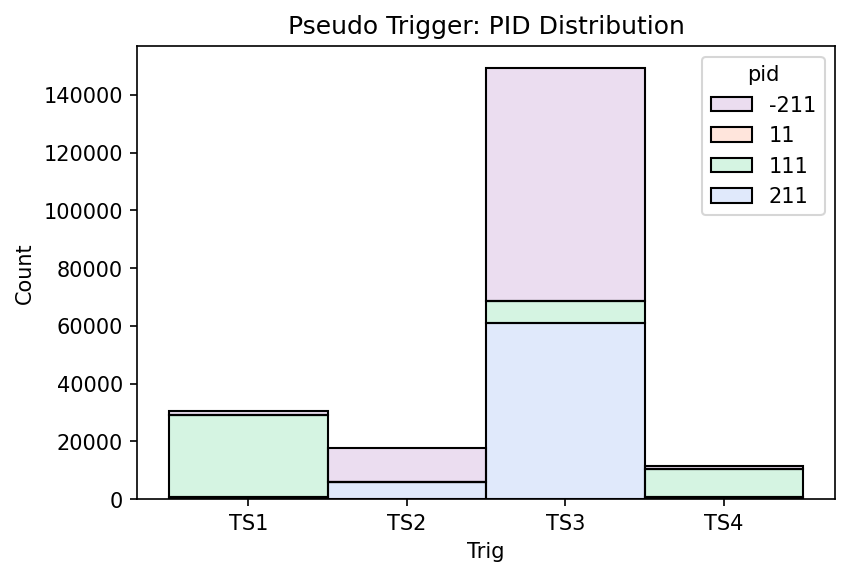

In [16]:
plt.figure(dpi=150)
plt.title("Pseudo Trigger: PID Distribution")
sns.histplot(Trig_Sim, x="Trig", hue="pid", binwidth=.5, multiple="stack", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.2)

#plt.yscale("log")
#plt.yticks(np.arange(0,16000+1,500),minor=1)

plt.show()

### Trigger Cher


In [17]:
%%time

channel_list = [[] for _ in range(16)]
    
for row in Trig_Sim["Cer"]:#[data0["TrigType"] == 32]:
    for i in range(len(row)):
        channel_list[i].append(row[i])
        
Trig_Cer_array = np.array(channel_list).T

CPU times: user 2.7 s, sys: 139 ms, total: 2.84 s
Wall time: 2.83 s


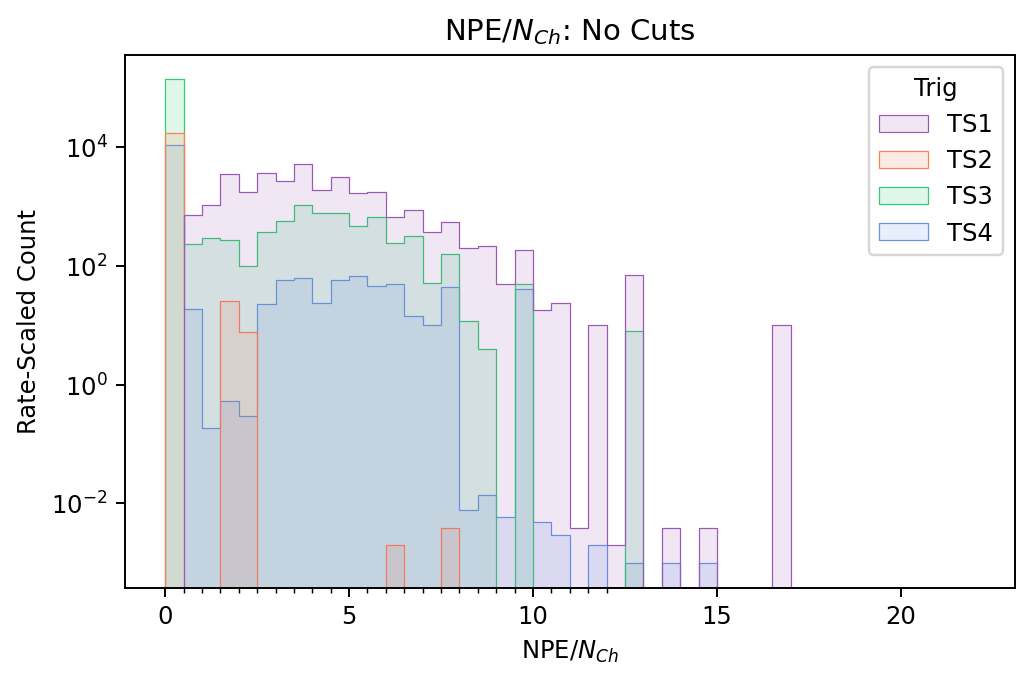

In [68]:
plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: No Cuts")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")
plt.ylabel("Rate-Scaled Count")

keeps = (Trig_Sim["Npesum"]>-10) #& ((sim_df["ShowerSum"]>200) | (sim_df["pid"]!=11)) & ((Clust_x**2 + Clust_y**2)**0.5 < 2)

Trig_Sim["NPE_NCh"] = Trig_Sim["Npesum"]/((Trig_Cer_array>0).sum(axis=1)+0.0001)

sns.histplot(Trig_Sim[keeps], x="NPE_NCh", hue="Trig", binwidth=.5, element="step", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
plt.savefig(f"Plots/NewCher_Trig_NPE_Per_NCh_NoCuts.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

In [69]:
channel_bool_val = (Trig_Cer_array > 0) 
good_array = get_good_array_sim(channel_bool_val)

plot_data = pd.DataFrame({'New_NPE':((Trig_Cer_array*good_array[None,:])).sum(axis=2).flatten(), 
                          'Num_Ch':good_array.sum(axis=1),
                          'Trig':Trig_Sim["Trig"],
                          'rate':Trig_Sim["rate"]})

plt.figure(dpi=175)
plt.title("NPE/$N_{Ch}$: Coincidence")# Shower Center [<2 cm] & ShowerSum [>200 MeV for e]")
plt.xlabel("NPE/$N_{Ch}$")
plt.ylabel("Rate-Scaled Count")

keeps = (plot_data["New_NPE"]>-10) #& ((sim_df["ShowerSum"]>200) | (sim_df["pid"]!=11)) & ((Clust_x**2 + Clust_y**2)**0.5 < 2)

plot_data["NPE_NCh"] = plot_data["New_NPE"]/(plot_data["Num_Ch"]+0.0001)

sns.histplot(plot_data[keeps], x="NPE_NCh", hue="Trig", binwidth=.5, element="step", weights="rate",
             palette=sns.color_palette(best_colors[:-1]), alpha=0.15, linewidth=0.5)

plt.yscale("log")
#plt.xlim(0,81)
plt.xticks(np.arange(0,12.1,0.5), minor=1)

plt.tight_layout()
plt.savefig(f"Plots/NewCher_Trig_NPE_Per_NCh_Coin.pdf") #CenterCut_HighEnergyCut_Onlye.pdf")
plt.show()

NameError: name 'get_good_array_sim' is not defined